In [1]:
import os
import shutil
from collections import defaultdict
import numpy as np
import cv2

TRAIN_SIZE_PER_CLASS = 20
MAX_TEST_SIZE_PER_CLASS = 5
MAX_CLASS_NUM = 50
CUT_SIZE = 81 * 81
RE_SIZE = (30,30)
FEATURE_DIM = 900
FEAT_TYPE = 'downsample'

def random_face_feature_extractor(in_dim, out_dim):
    """随机特征提取矩阵 返回R 对于一维图像数据A RA表示一维图像特征 randomface"""
    R = np.random.randn(out_dim, in_dim)  # 每个元素服从正态分布
    R /= np.sum(R, axis=1, keepdims=True)  # 每一行表示一个randomface
    return R
    
def read_gray_cut_flatten_feat_from_img_path(img_path, feat_type, cut_range):
    img_gray = cv2.cvtColor(cv2.imread(data_path), cv2.COLOR_RGB2GRAY)[cut_range, cut_range]
    if feat_type == 'downsample':
        return cv2.resize(img_gray, RE_SIZE).flatten().astype(float)
    else:
        return np.dot(R, img_gray.flatten())
        
#dataset_root_path = 'lfw-deepfunneled'  # 数据集目录 该目录下为 包含人类数据的文件夹 
dataset_root_path = 'CroppedYale'
skip = 4 if dataset_root_path == 'CroppedYale' else 0  # 跳过无用文件
cut_range = slice(90, 171) if dataset_root_path == 'lfw-deepfunneled' else slice(None)
RE_SIZE = (30,30) if dataset_root_path == 'lfw-deepfunneled' else (12, 12)
R = random_face_feature_extractor(CUT_SIZE, FEATURE_DIM)  # randomfaces 特征

RA = []  # 字典矩阵
test_data = defaultdict(list) # 测试数据
class2index = {}  # 标签

# 数据处理 使用训练数据的特征拼接字典矩阵 准备测试数据的特征
for classi in os.listdir(dataset_root_path):
    class_data_path = os.path.join(dataset_root_path, classi)
    class_data = os.listdir(class_data_path)
    # 删除多余的文件
    if len(class_data) < skip + TRAIN_SIZE_PER_CLASS + 1 or len(test_data) == MAX_CLASS_NUM:
        shutil.rmtree(class_data_path)
        continue
    class2index[classi] = len(test_data)
    # 训练数据 从灰度图抽取特征RA_i后拼接成RA
    for d in class_data[skip:TRAIN_SIZE_PER_CLASS+skip]:
        data_path = os.path.join(class_data_path, d)
        RA.append(read_gray_cut_flatten_feat_from_img_path(data_path, feat_type=FEAT_TYPE, cut_range=cut_range))
    # 测试数据 从灰度图抽取特征RA_i后归入所属类别
    last = min(len(class_data), TRAIN_SIZE_PER_CLASS + skip + MAX_TEST_SIZE_PER_CLASS)
    for d in class_data[TRAIN_SIZE_PER_CLASS+skip:last]:
        data_path = os.path.join(class_data_path, d)
        test_data[classi].append(read_gray_cut_flatten_feat_from_img_path(data_path, feat_type=FEAT_TYPE, cut_range=cut_range))
    # 删除多余的文件
    if last < len(class_data):
        for d in class_data[last:]:
            os.remove(os.path.join(class_data_path, d))
            
RA = np.array(RA).transpose()  # 特征维度x数据量 每列是一个特征
RA /= np.sum(RA ** 2, axis = 0, keepdims=True) ** 0.5  # 每一列进行二范数单位化

print("---数据集信息---")
print("使用{}特征的表示字典大小为：".format(FEAT_TYPE), RA.shape, "，表示不同人脸的特征，每{}张人脸属于一个人".format(TRAIN_SIZE_PER_CLASS))
print("一共{}个类别, {}份测试数据".format(len(test_data), sum([len(test_data[i]) for i in test_data])))

---数据集信息---
使用downsample特征的表示字典大小为： (144, 760) ，表示不同人脸的特征，每20张人脸属于一个人
一共38个类别, 190份测试数据


In [2]:
import matplotlib.pyplot as plt
import cvxpy as cvx

def soft_threshold(threshold, x):
    return np.sign(x) * (x * (abs(x) - threshold) > 0)

def lasso_cvx(B, b, eps, epochs=100, display=False):
    """使用cvxpy 求解LASSO"""
    w = cvx.Variable(B.shape[1])
    cvx.Problem(cvx.Minimize(cvx.sum_squares(B@w - b)), [cvx.norm(w, 1) <= 1]).solve()
    return w.value

def lasso_admm(B, b, eps, epochs=1000, display=False):
    """使用交替方向乘子法 求解LASSO"""
    p = np.linalg.norm(b) / B.shape[0]
    c = 0.01 * p
    w = np.zeros(B.shape[1])
    best_w = None
    min_l = 0x3f3f3f3f
    y = w.copy()
    z = w.copy()
    I = np.eye(B.shape[1])
    if display:
        loss1, loss2 = [], []
    BTB_CI_1 = np.linalg.inv(np.dot(B.T, B) + c * I)
    BTb = np.dot(B.T, b)
    for _ in range(epochs):
        last_w = w
        w = np.dot(BTB_CI_1, BTb + c * (y - z))
        y = soft_threshold(p / c, z + w)
        z = z + w - y
        l1, l2 = 0.5 * np.linalg.norm(np.dot(B, w) - b), np.linalg.norm(w, ord=1)
        if l1 + l2 < min_l:
            min_l = l1 + l2
            best_w = w
        if display:
            loss1.append(l1)
            loss2.append(l2)
        if np.linalg.norm(w - last_w) < eps:
            break
    if display:
        plt.plot(loss1, label='1/2||Bw-b||')
        plt.plot(loss2, label='p||w||')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()
    return best_w

def lasso_dalm(B, b, eps, epochs=1000, display=False):
    """使用对偶增广拉格朗日法 求解LASSO"""
    w = np.zeros(B.shape[1])
    y = np.zeros(B.shape[0])
    A = B[:, :-B.shape[0]] * (2 ** 0.5)
    G = (np.dot(A, A.T) + np.eye(B.shape[0])) / 2
    invG = np.linalg.inv(G)
    invG_Av = np.dot(invG, B)
    invG_bv = np.dot(invG, b)
    beta = np.linalg.norm(b) / B.shape[0]
    if display:
        loss1, loss2 = [], []
    BTy = np.dot(B.T, y)
    for _ in range(epochs):
        z = (BTy + w / beta)
        z[abs(z) > 1] = np.sign(z)[abs(z) > 1]
        
        y = np.dot(invG_Av, (z - w / beta)) + invG_bv / beta
        BTy = np.dot(B.T, y)
        
        last_w = w
        w = w - beta * (z - BTy)
        if display:
            loss1.append(0.5 * np.linalg.norm(np.dot(B, w) - b))
            loss2.append(np.linalg.norm(w, ord=1))
        if np.linalg.norm(w - last_w) < eps:
            break
    if display:
        plt.plot(loss1, label='1/2||Bw-b||')
        plt.plot(loss2, label='p||w||')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()
    return w    

In [3]:
def sparse_representation_classify(A, y, eps, num_class, lasso_solver, display=False):
    B = np.append(A, np.eye(A.shape[0]), axis=1) / (2 ** 0.5)  # [A I]单位化
    y = (y / (np.sum(y ** 2) ** 0.5)) / (2 ** 0.5)
    assert A.shape[1] % num_class == 0
    class_size = A.shape[1] // num_class
    w = lasso_solver(B, y, eps, display=display)
    x, e = w[:A.shape[1]], w[A.shape[1]:]
    y_r = y - e
    residual = []
    ans = 0
    for i in range(0, num_class):
        x_i = x * [x[j] if j // class_size == i else 0 for j in range(len(x))]
        residual_i = np.linalg.norm(y_r - A.dot(x_i))
        residual.append(residual_i)
        if residual_i < residual[ans]:
            ans = i
    if display:
        plt.subplot(211)
        plt.plot(range(len(x)), x)
        plt.ylabel('coefficient')
        plt.xlabel('represent dict')
        plt.subplot(212)
        plt.bar(range(len(residual)), residual)
        plt.ylabel('residual')
        plt.xlabel('class')
        plt.show()
    return ans

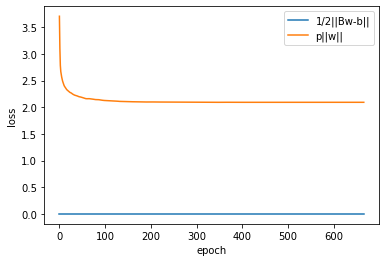

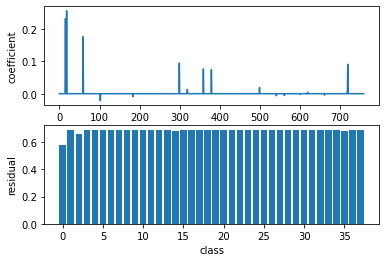

1.0


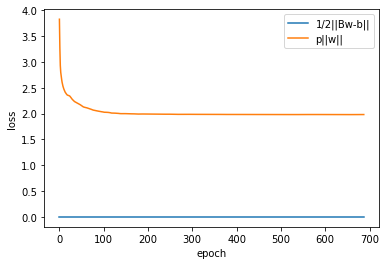

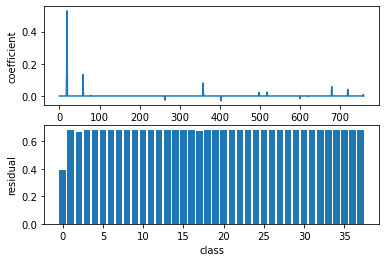

1.0


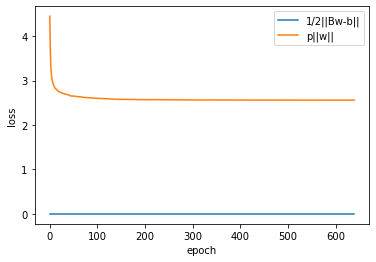

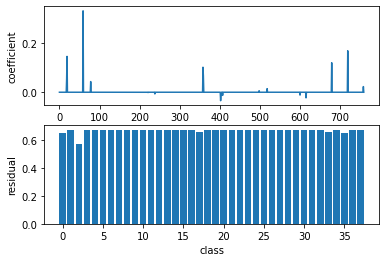

0.6666666666666666


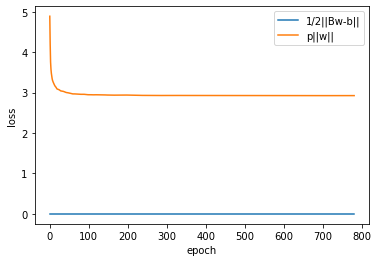

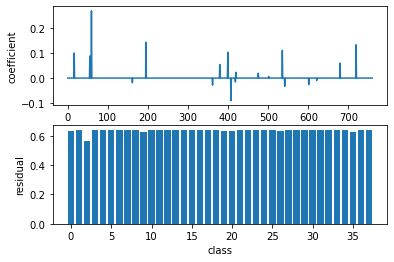

0.5


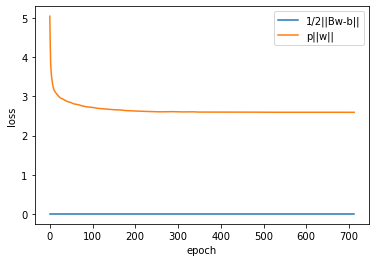

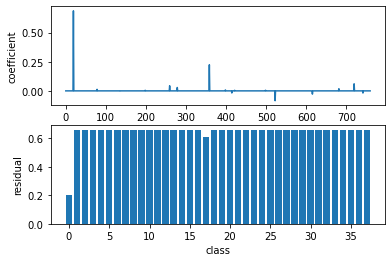

0.6


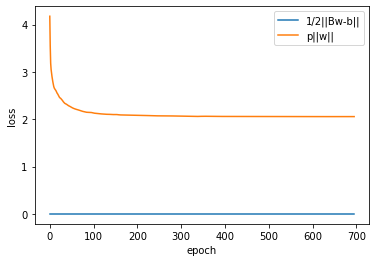

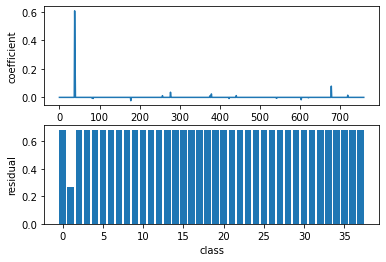

0.6666666666666666


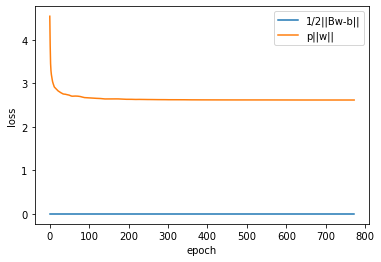

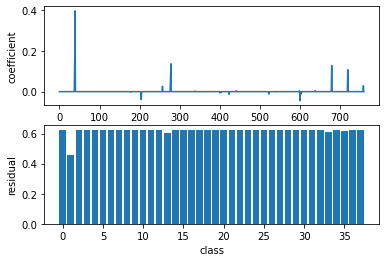

0.7142857142857143


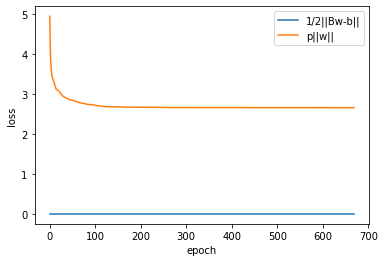

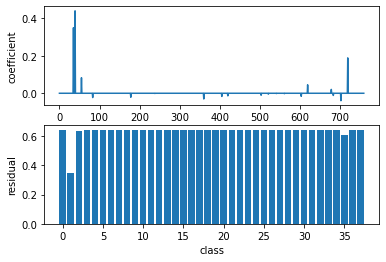

0.75


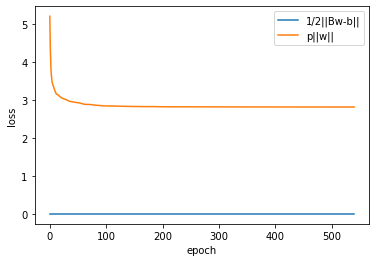

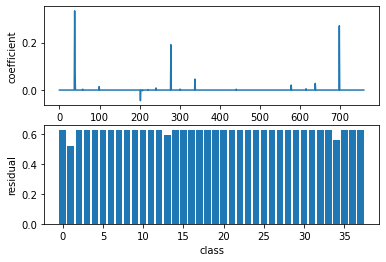

0.7777777777777778


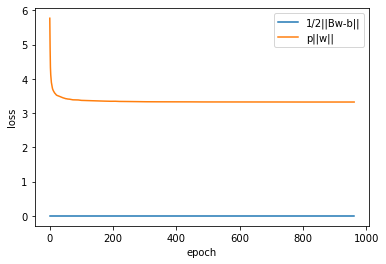

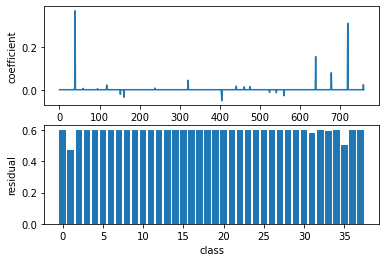

0.8


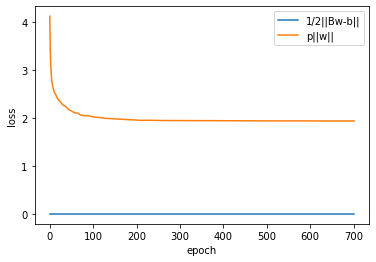

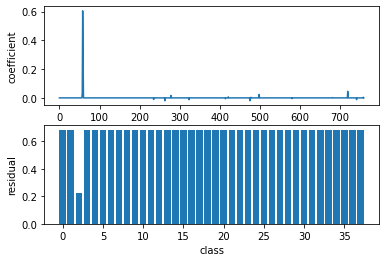

0.8181818181818182


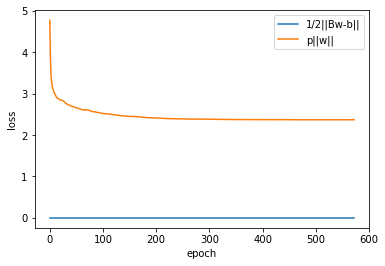

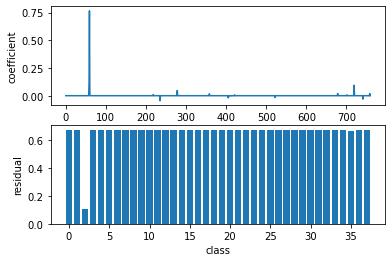

0.8333333333333334


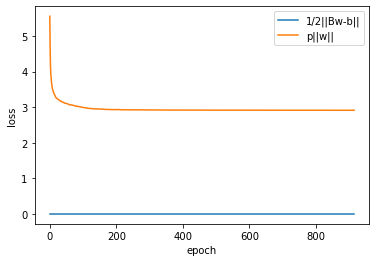

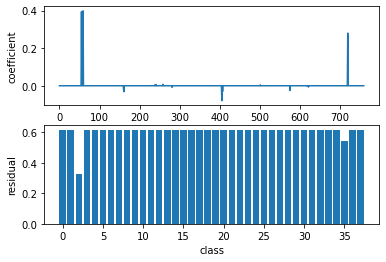

0.8461538461538461


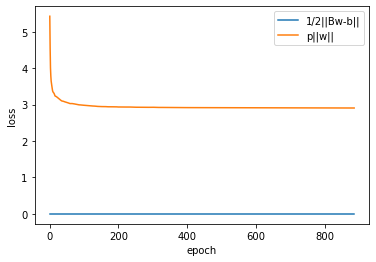

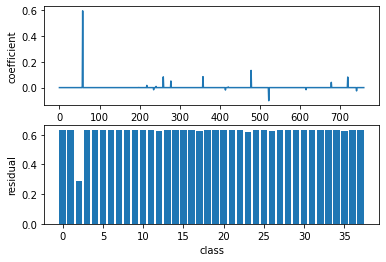

0.8571428571428571


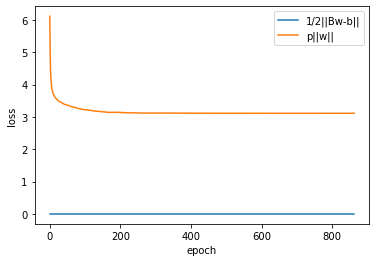

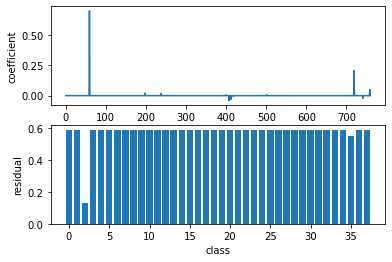

0.8666666666666667


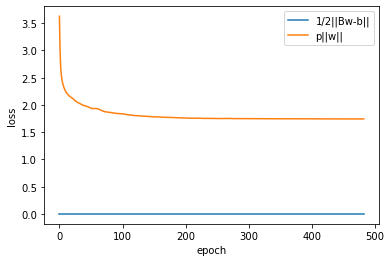

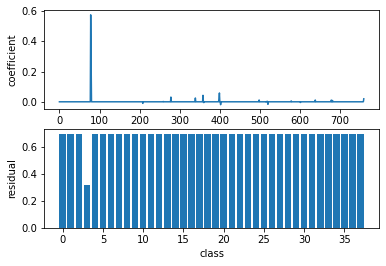

0.875


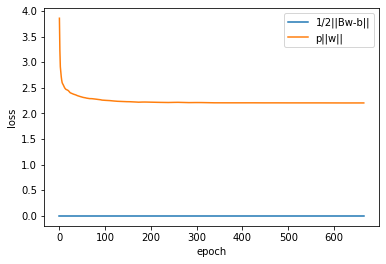

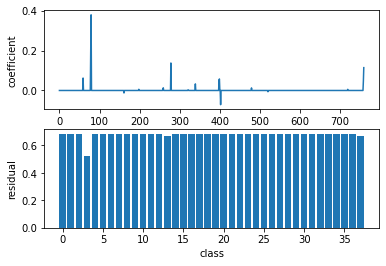

0.8823529411764706


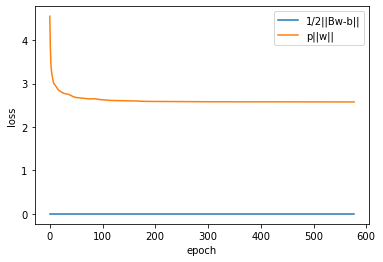

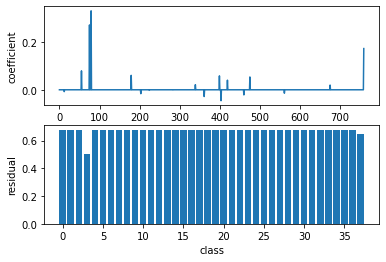

0.8888888888888888


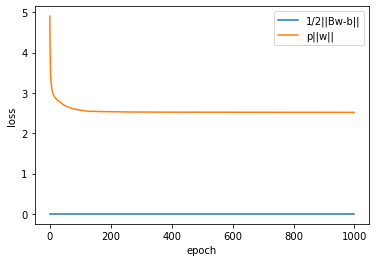

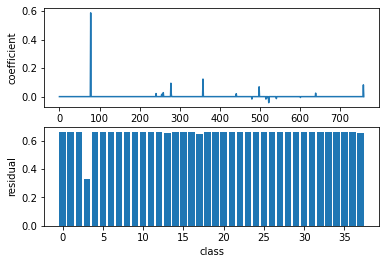

0.8947368421052632


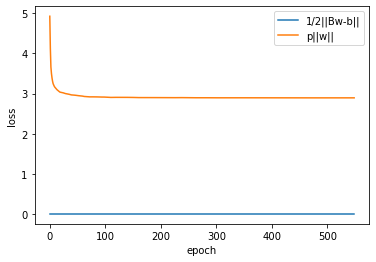

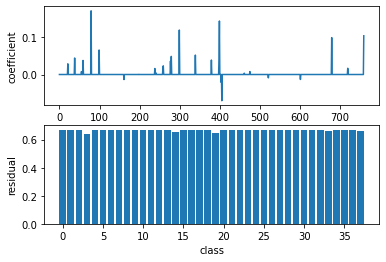

0.9


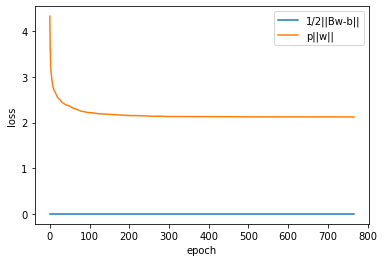

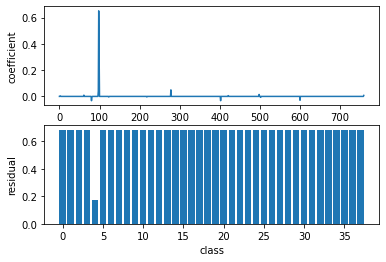

0.9047619047619048


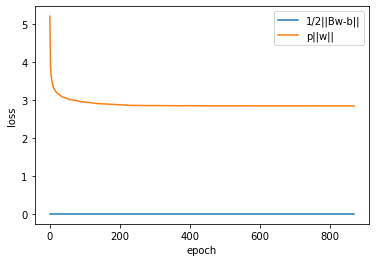

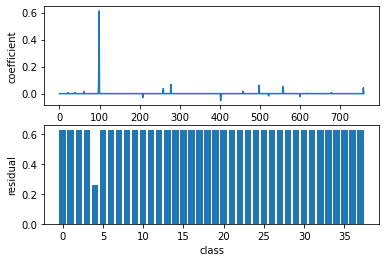

0.9090909090909091


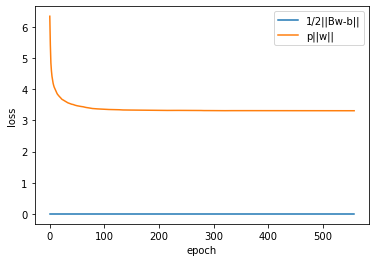

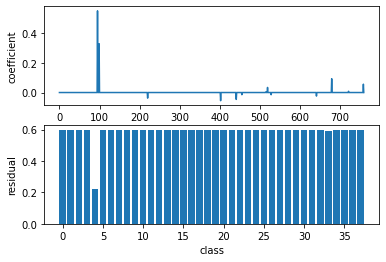

0.9130434782608695


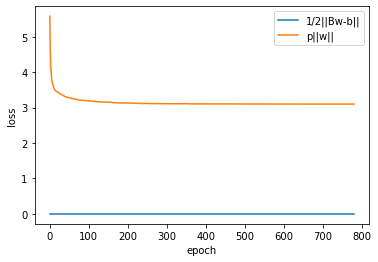

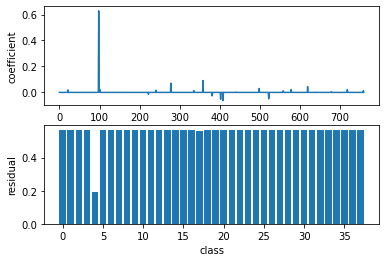

0.9166666666666666


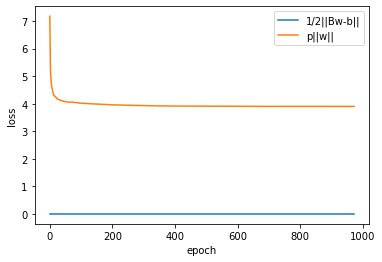

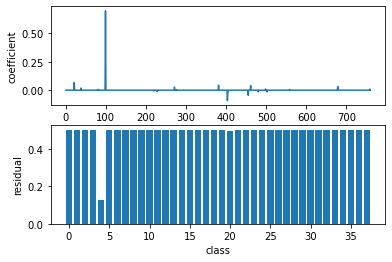

0.92


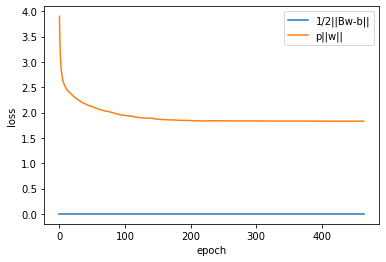

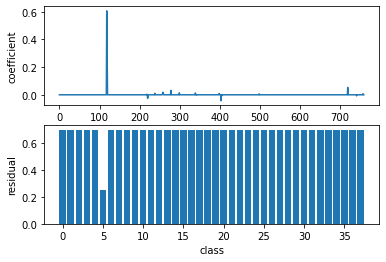

0.9230769230769231


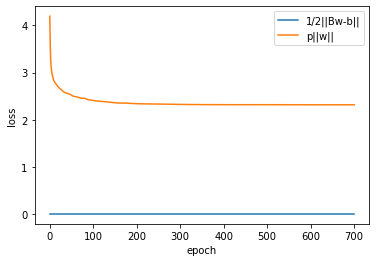

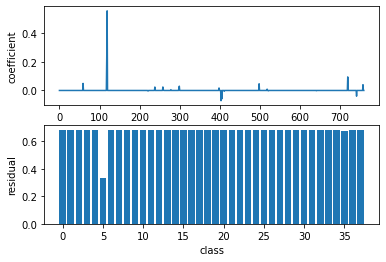

0.9259259259259259


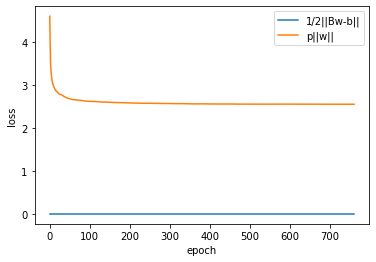

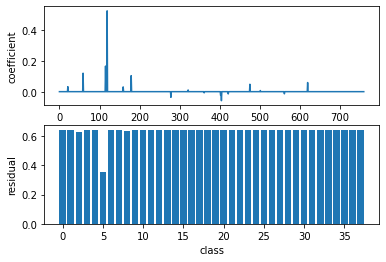

0.9285714285714286


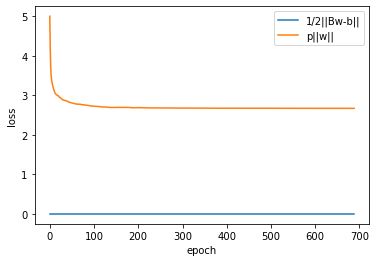

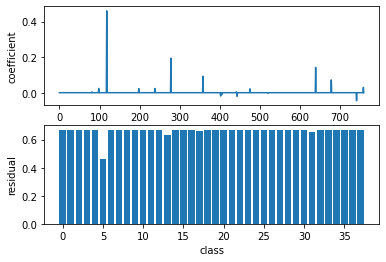

0.9310344827586207


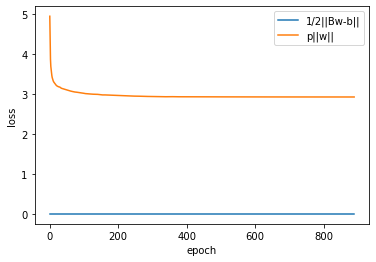

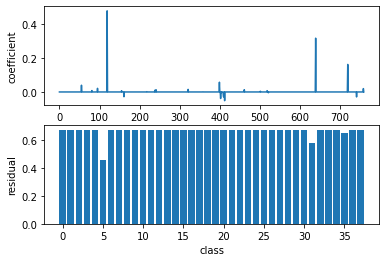

0.9333333333333333


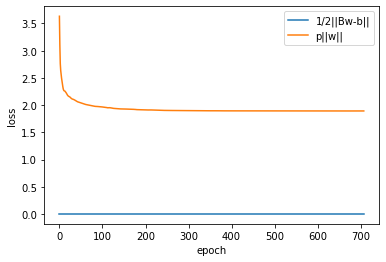

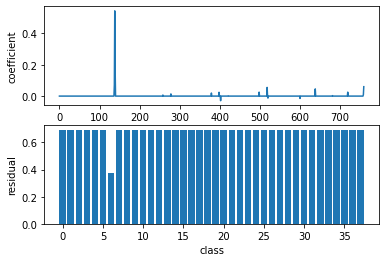

0.9354838709677419


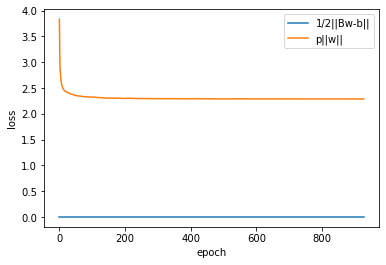

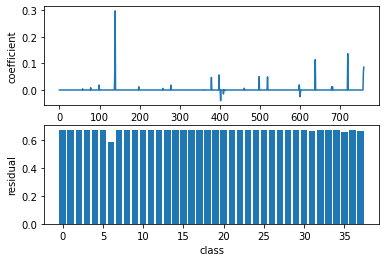

0.9375


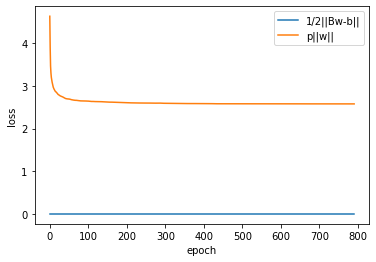

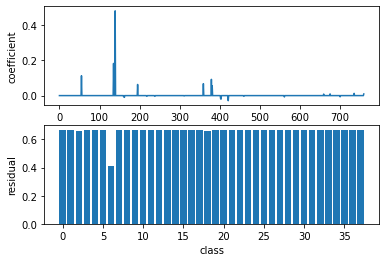

0.9393939393939394


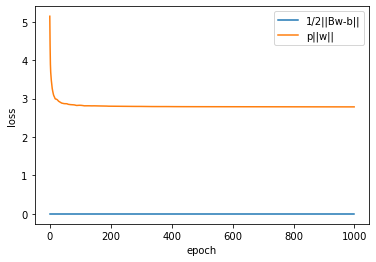

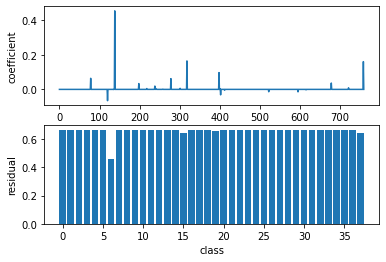

0.9411764705882353


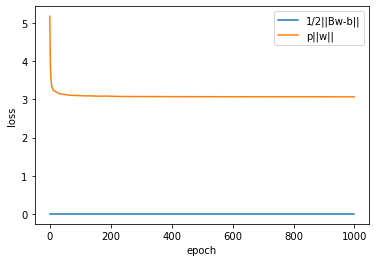

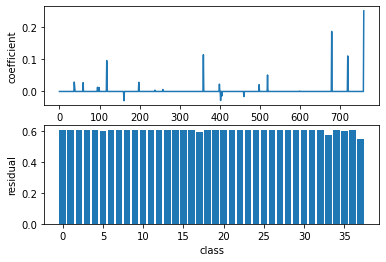

0.9142857142857143


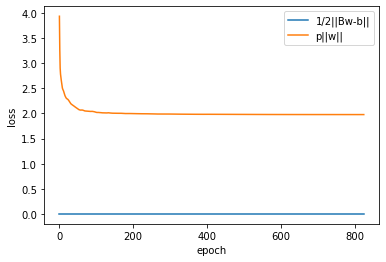

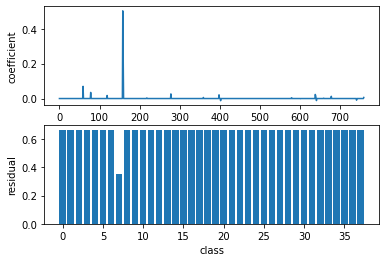

0.9166666666666666


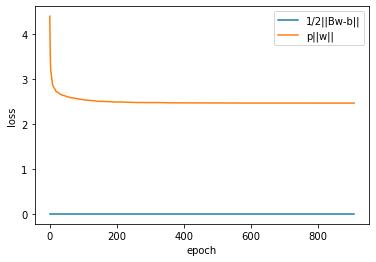

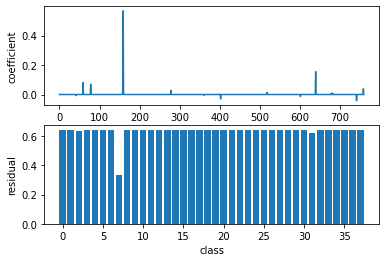

0.918918918918919


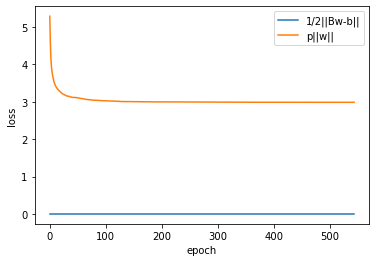

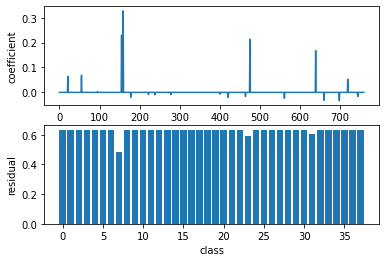

0.9210526315789473


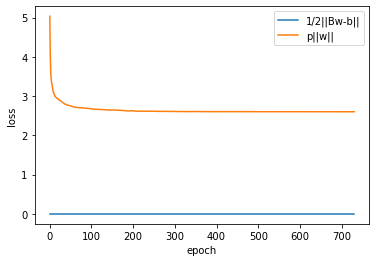

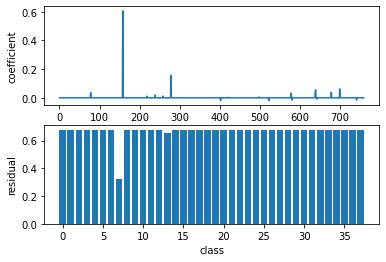

0.9230769230769231


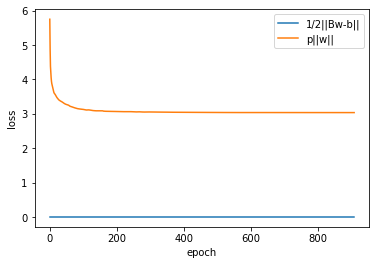

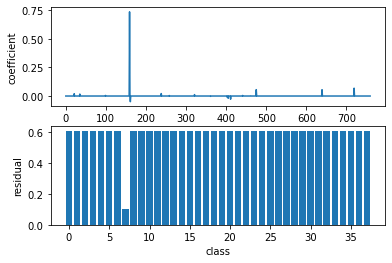

0.925


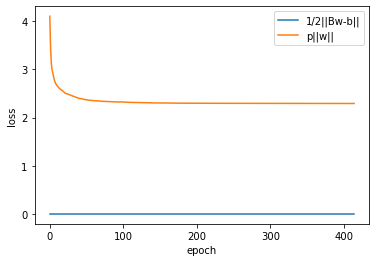

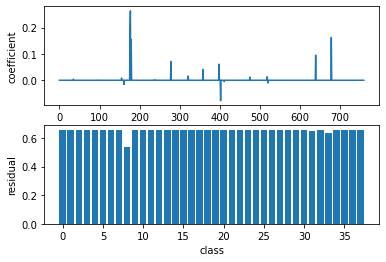

0.926829268292683


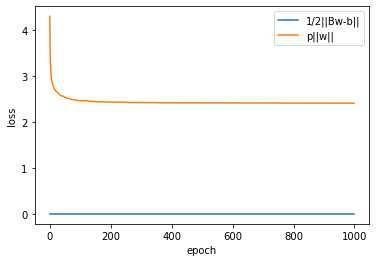

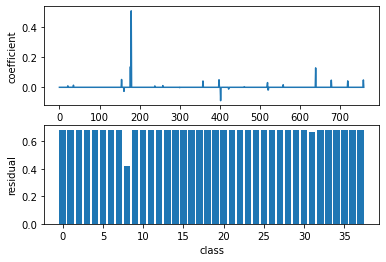

0.9285714285714286


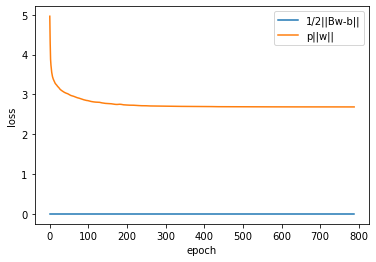

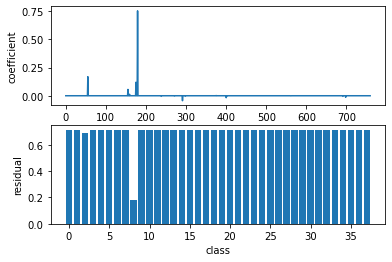

0.9302325581395349


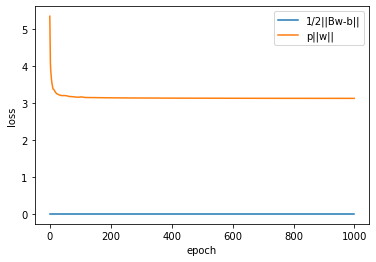

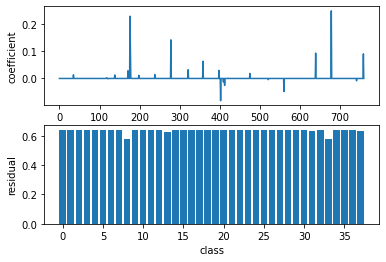

0.9318181818181818


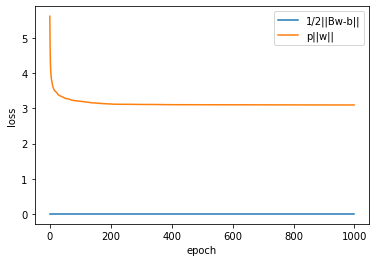

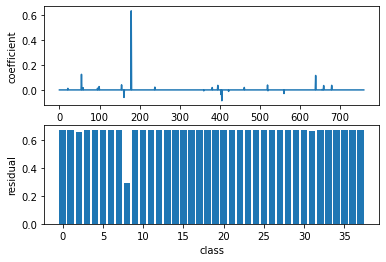

0.9333333333333333


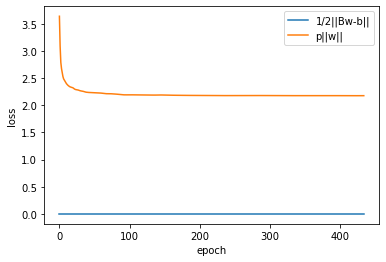

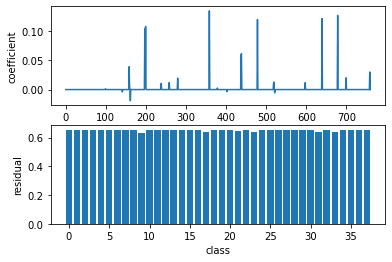

0.9347826086956522


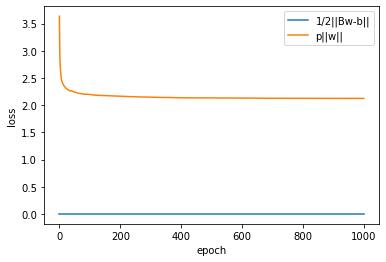

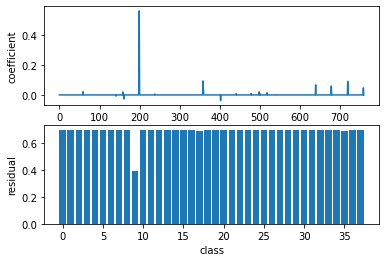

0.9361702127659575


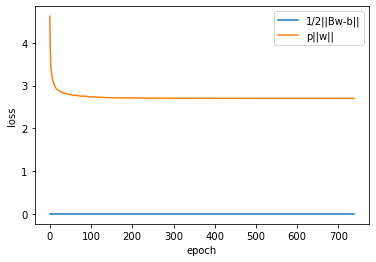

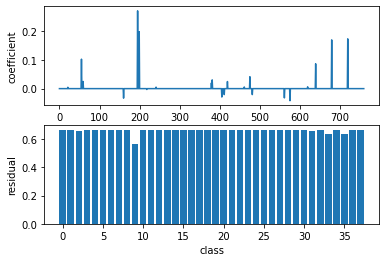

0.9375


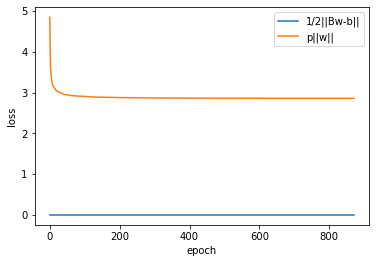

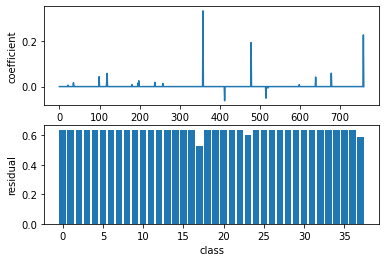

0.9183673469387755


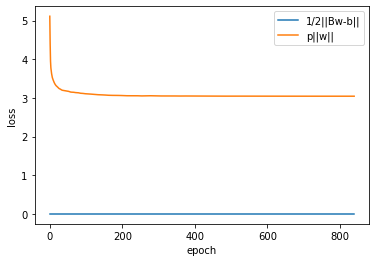

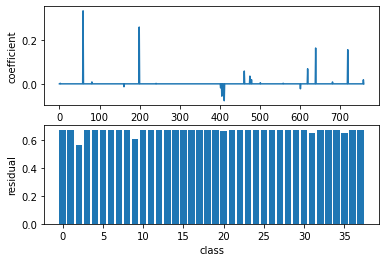

0.9


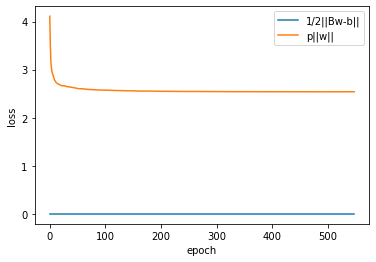

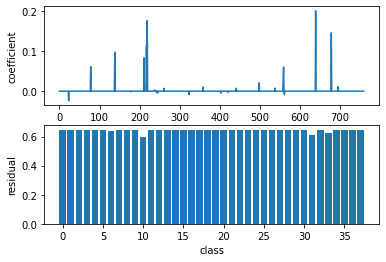

0.9019607843137255


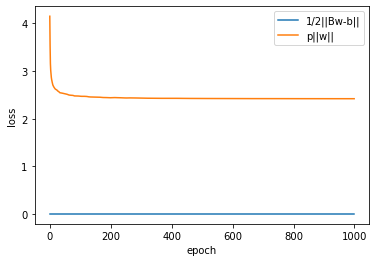

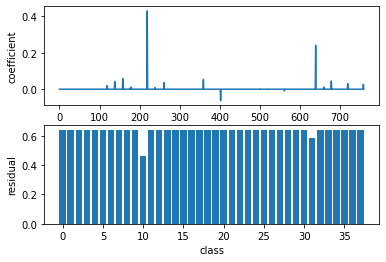

0.9038461538461539


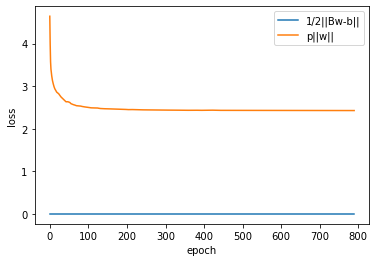

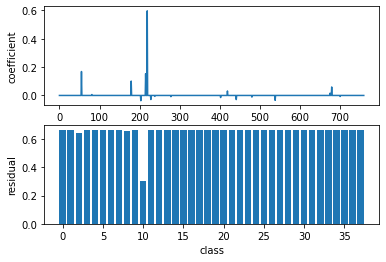

0.9056603773584906


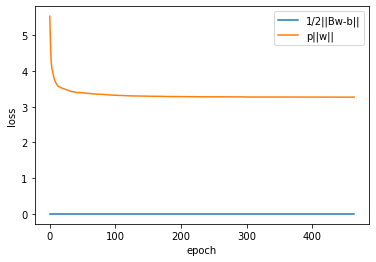

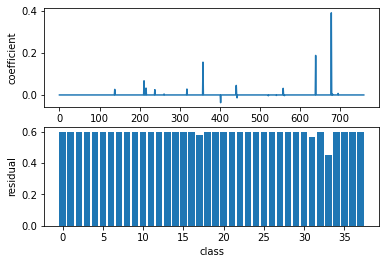

0.8888888888888888


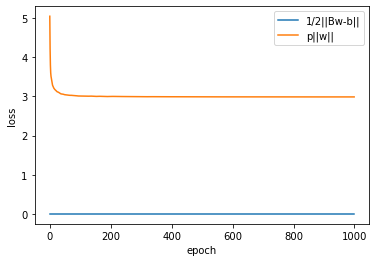

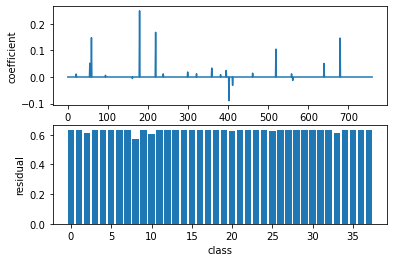

0.8727272727272727


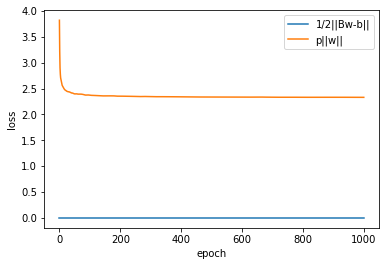

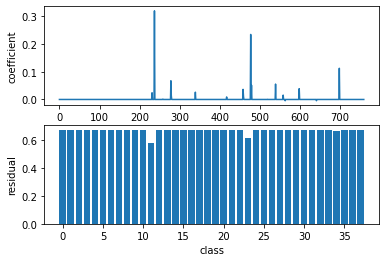

0.875


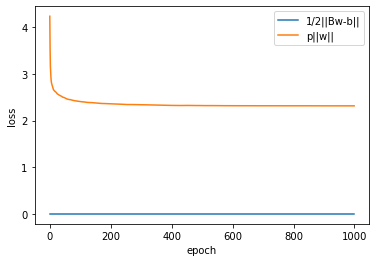

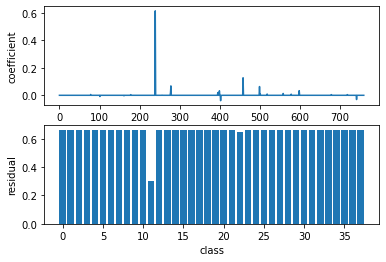

0.8771929824561403


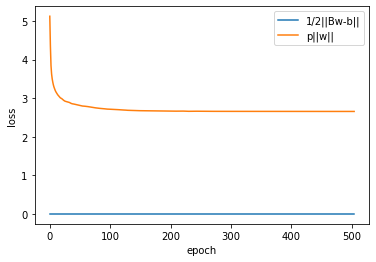

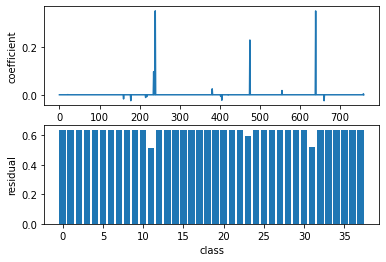

0.8793103448275862


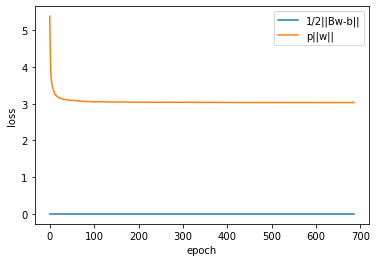

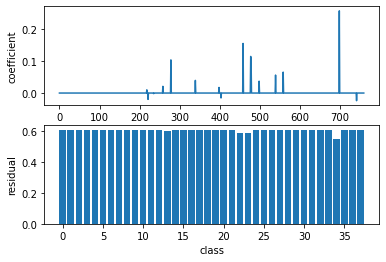

0.864406779661017


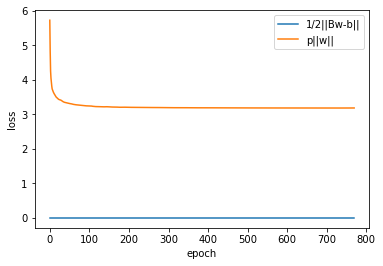

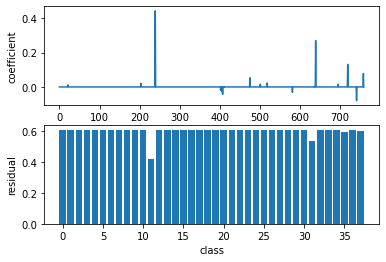

0.8666666666666667


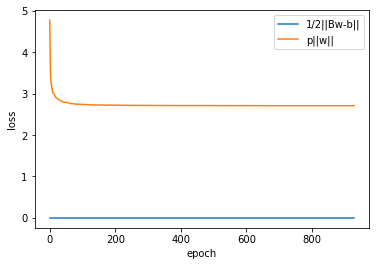

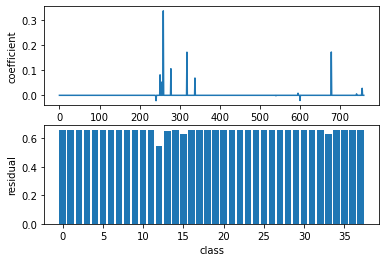

0.8688524590163934


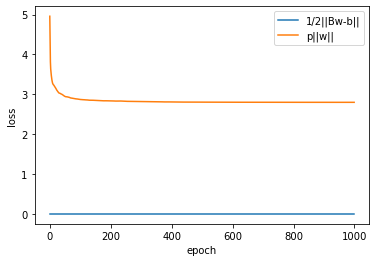

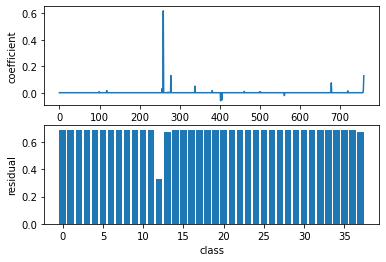

0.8709677419354839


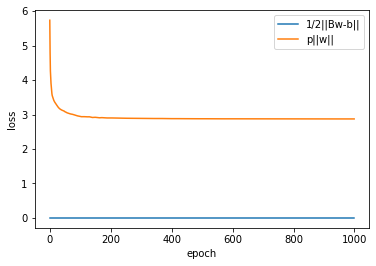

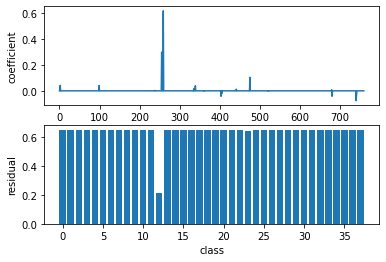

0.873015873015873


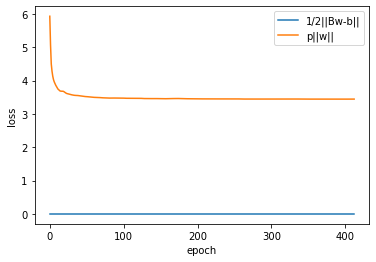

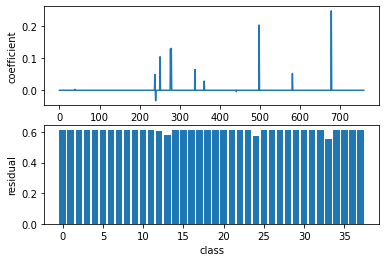

0.859375


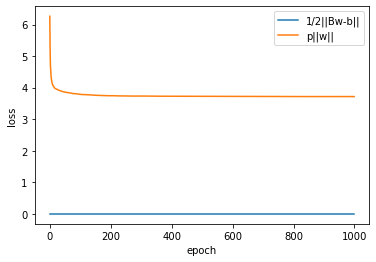

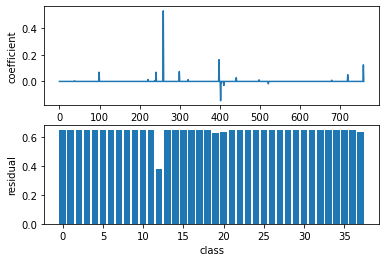

0.8615384615384616


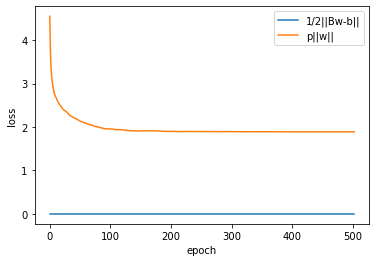

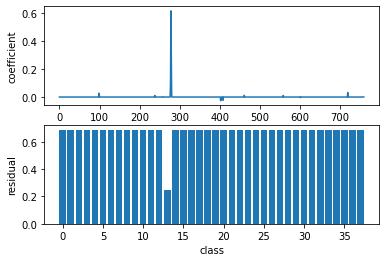

0.8636363636363636


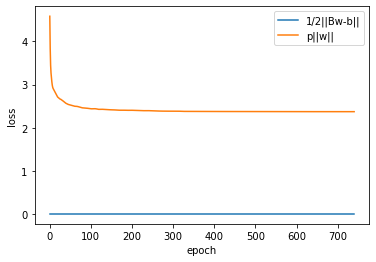

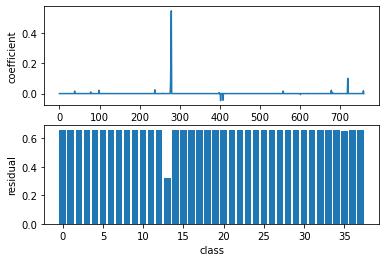

0.8656716417910447


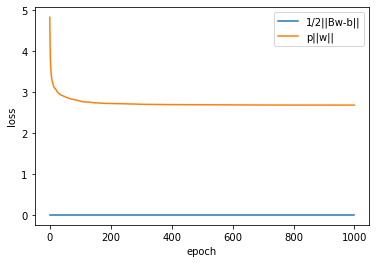

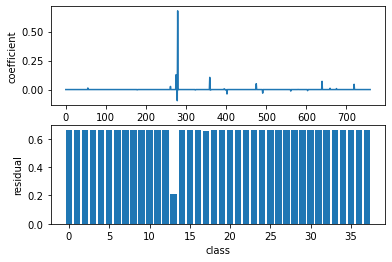

0.8676470588235294


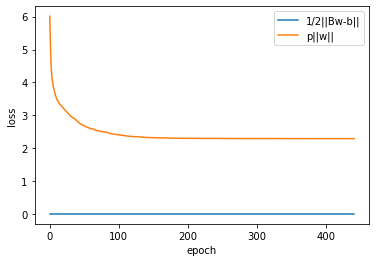

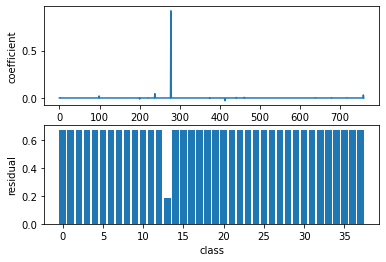

0.8695652173913043


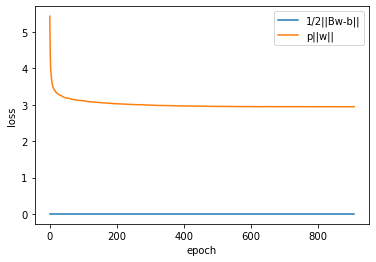

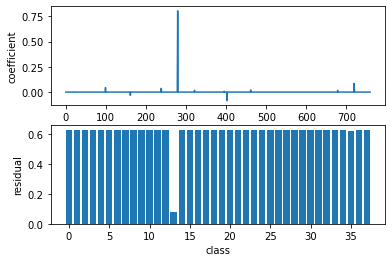

0.8714285714285714


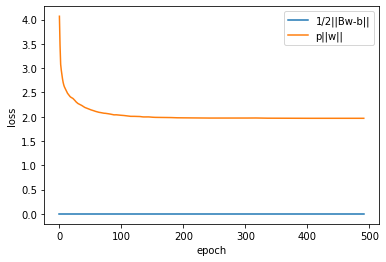

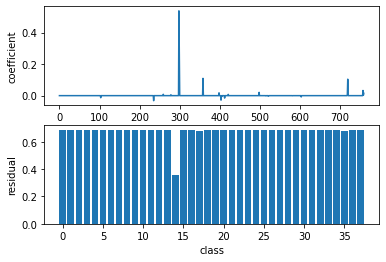

0.8732394366197183


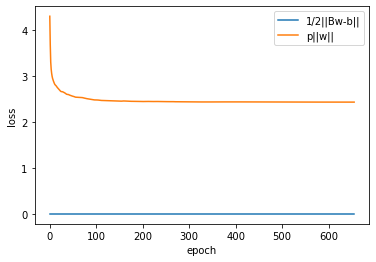

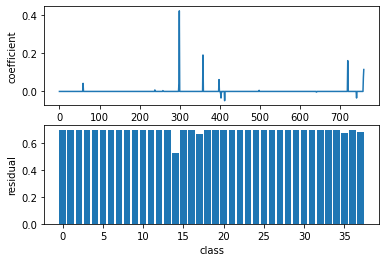

0.875


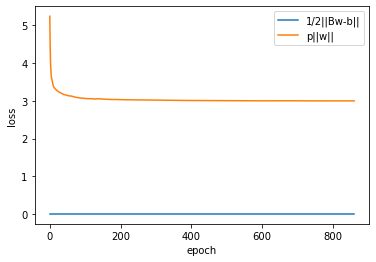

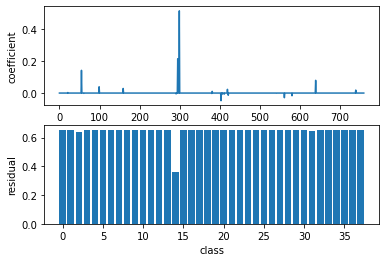

0.8767123287671232


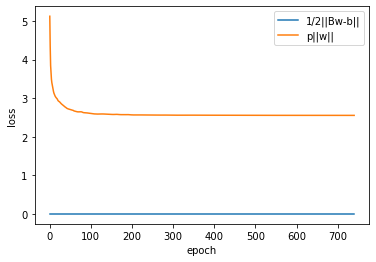

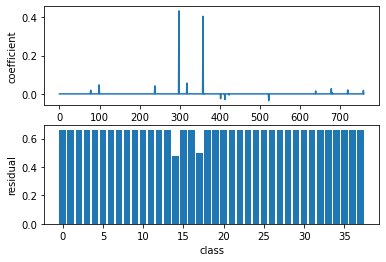

0.8783783783783784


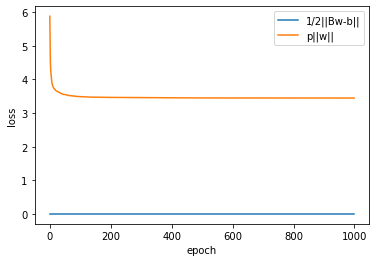

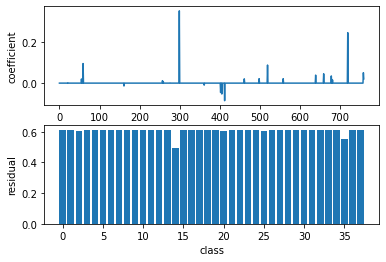

0.88


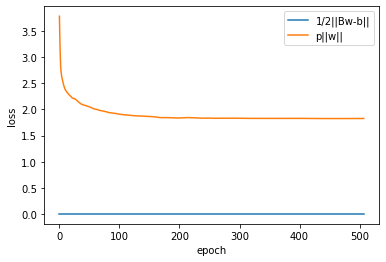

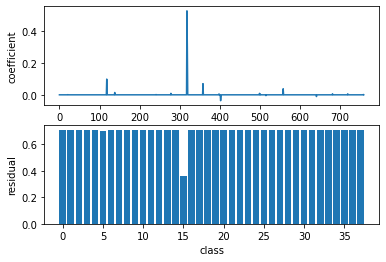

0.881578947368421


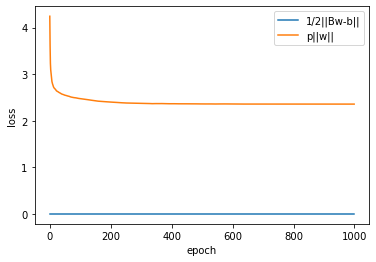

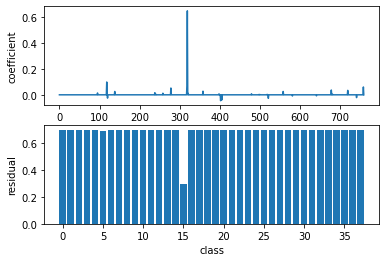

0.8831168831168831


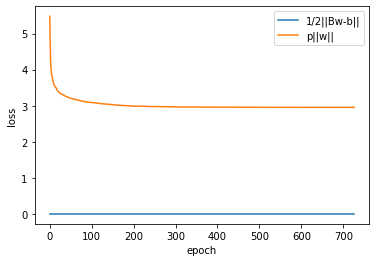

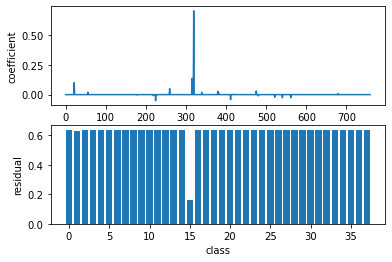

0.8846153846153846


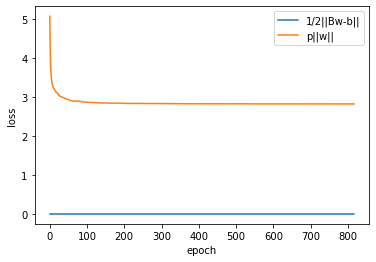

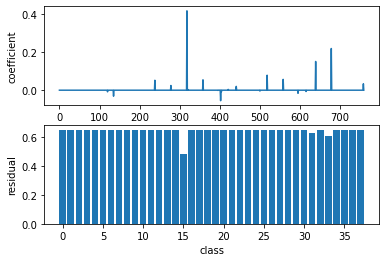

0.8860759493670886


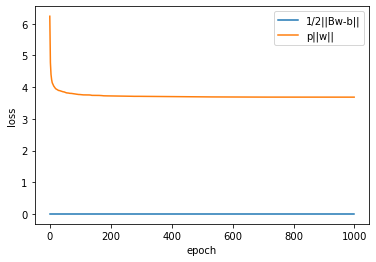

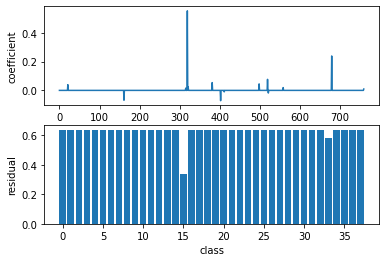

0.8875


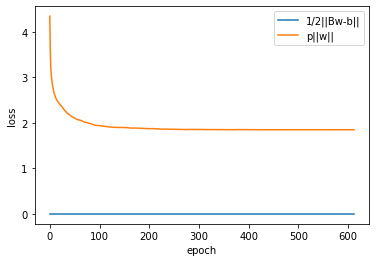

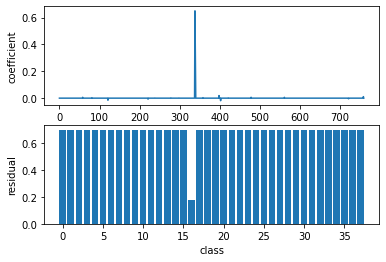

0.8888888888888888


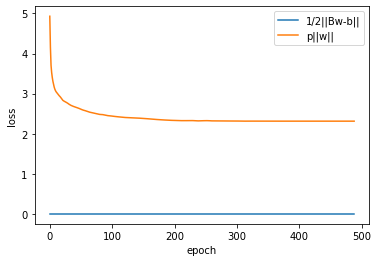

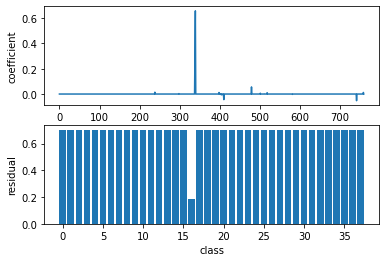

0.8902439024390244


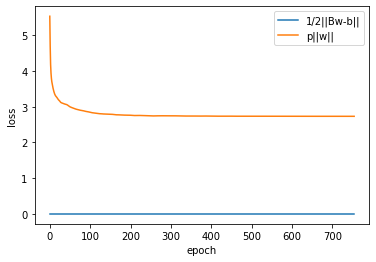

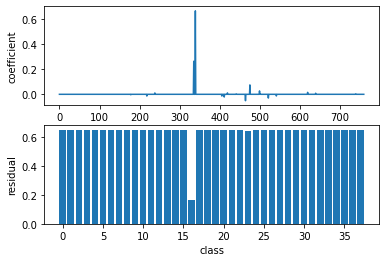

0.891566265060241


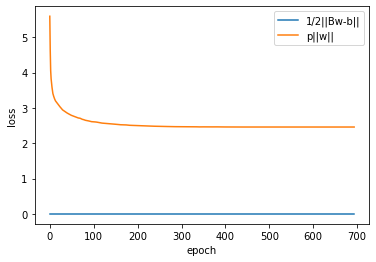

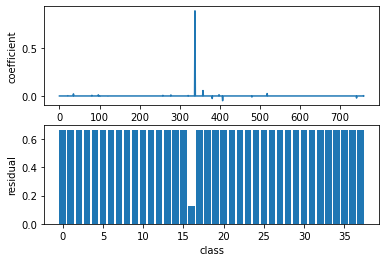

0.8928571428571429


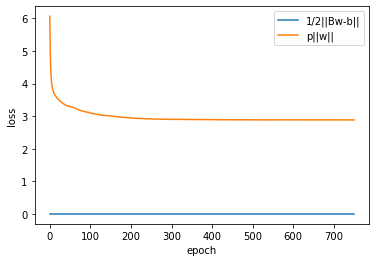

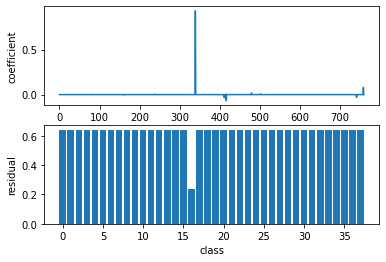

0.8941176470588236


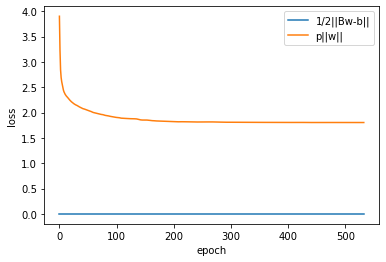

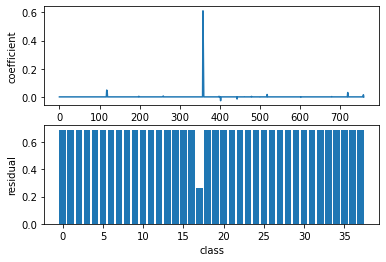

0.8953488372093024


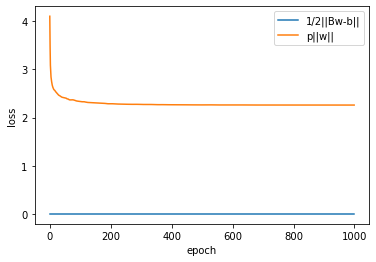

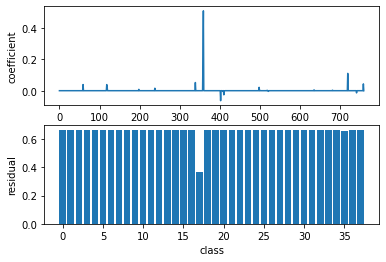

0.896551724137931


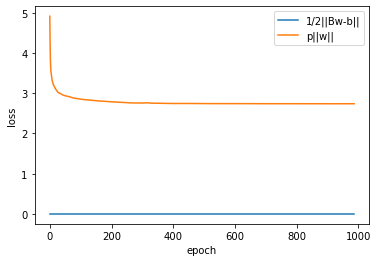

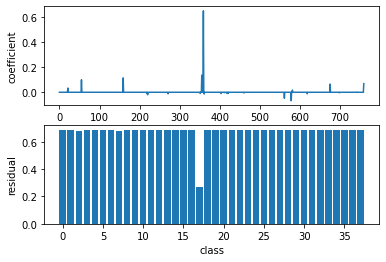

0.8977272727272727


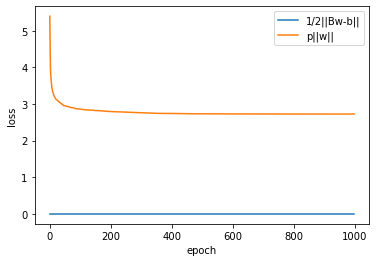

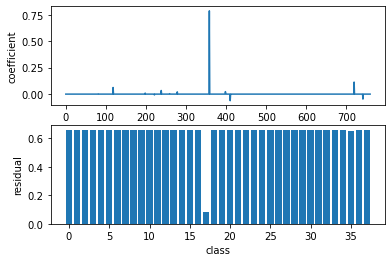

0.898876404494382


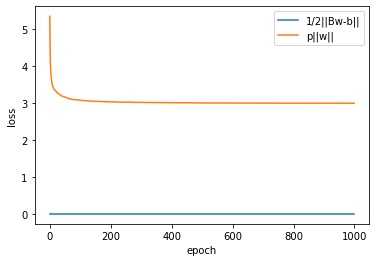

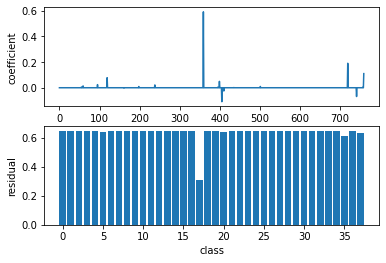

0.9


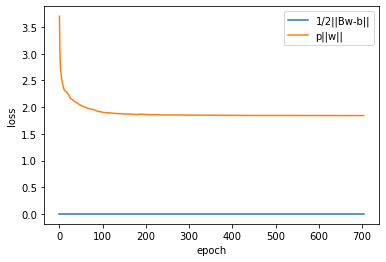

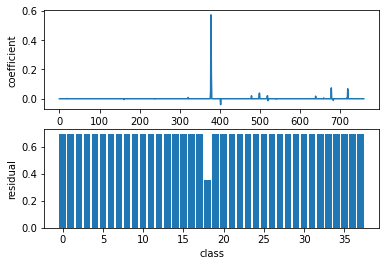

0.9010989010989011


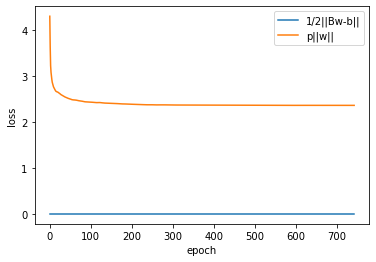

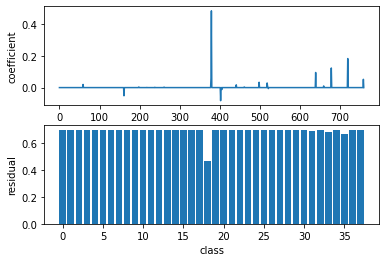

0.9021739130434783


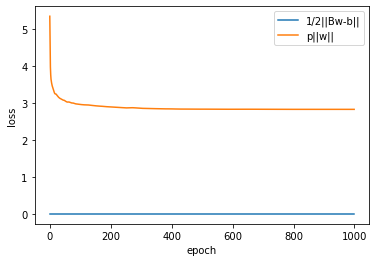

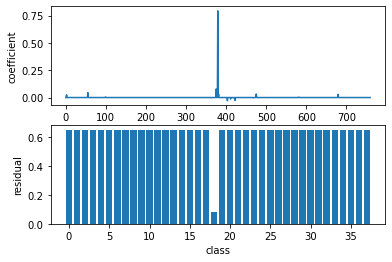

0.9032258064516129


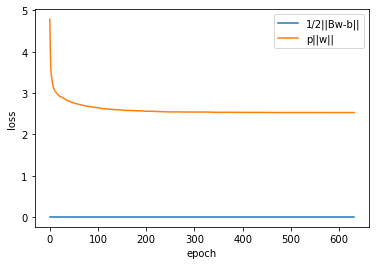

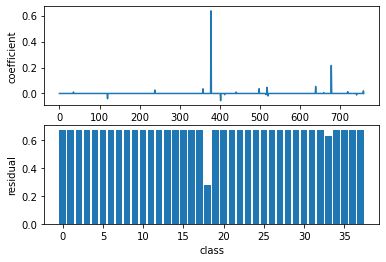

0.9042553191489362


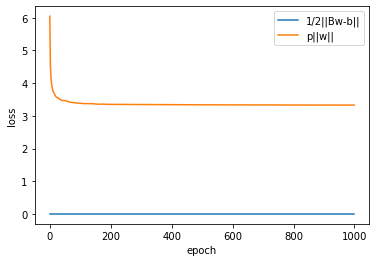

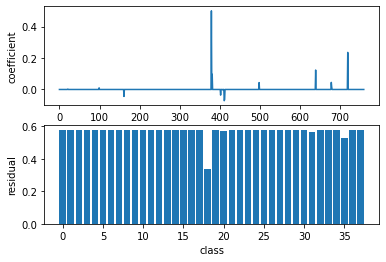

0.9052631578947369


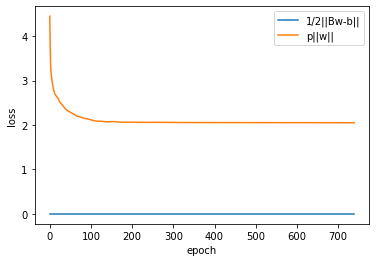

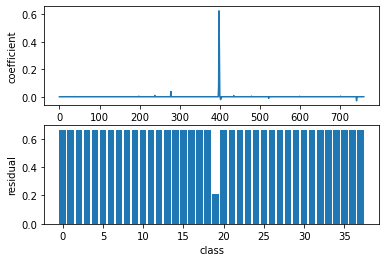

0.90625


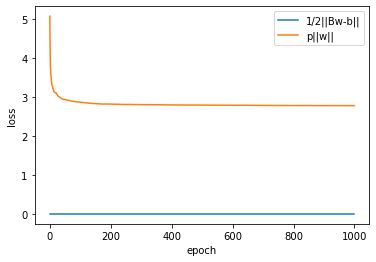

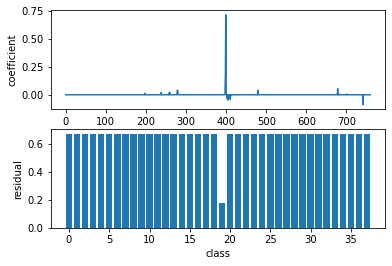

0.9072164948453608


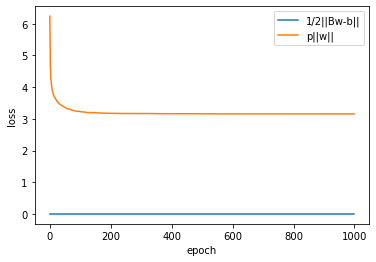

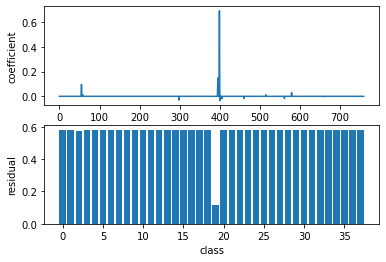

0.9081632653061225


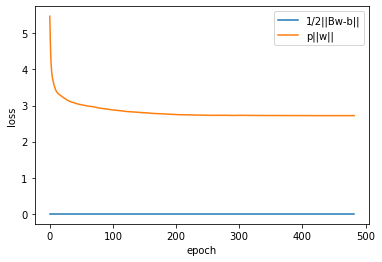

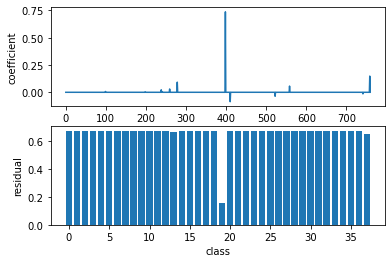

0.9090909090909091


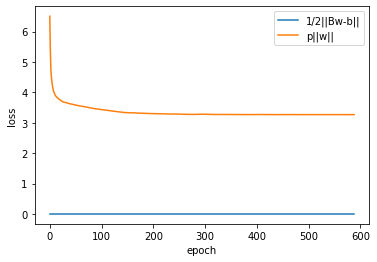

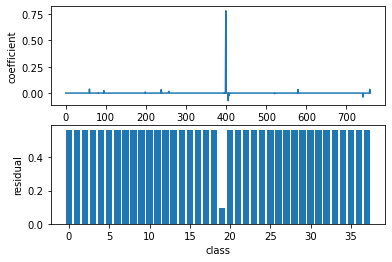

0.91


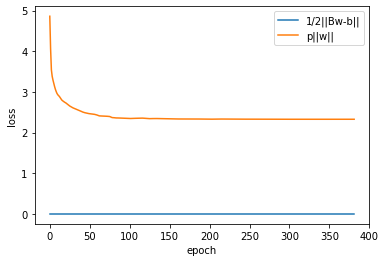

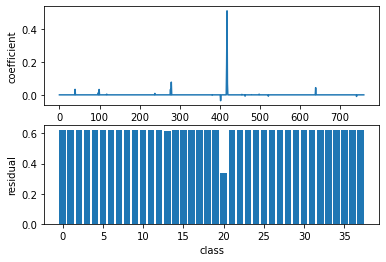

0.9108910891089109


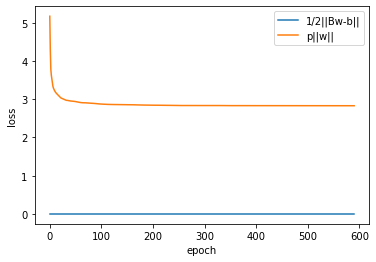

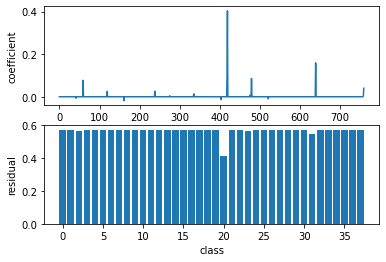

0.9117647058823529


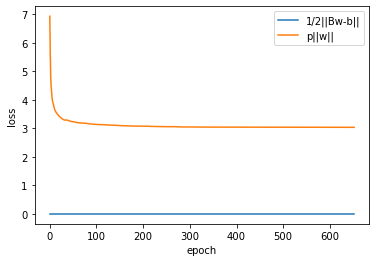

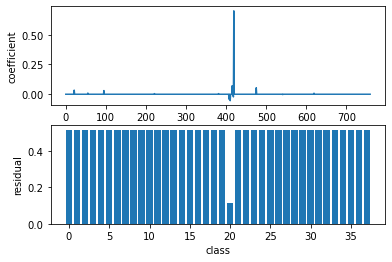

0.912621359223301


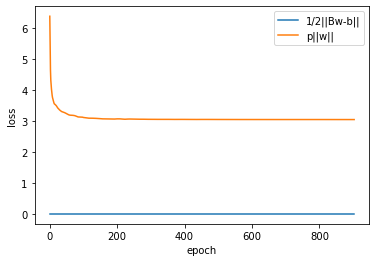

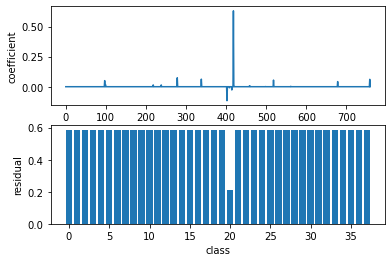

0.9134615384615384


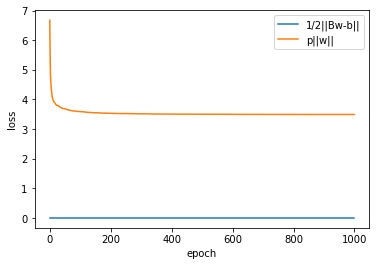

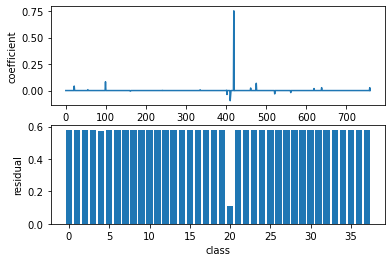

0.9142857142857143


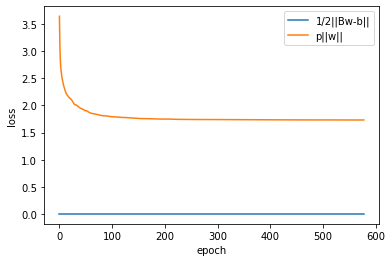

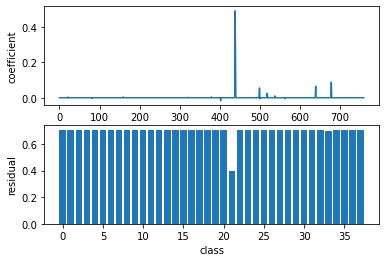

0.9150943396226415


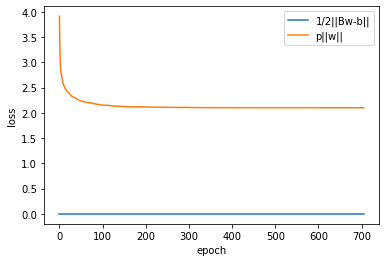

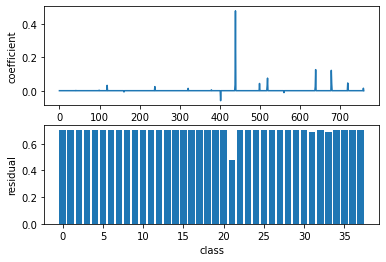

0.9158878504672897


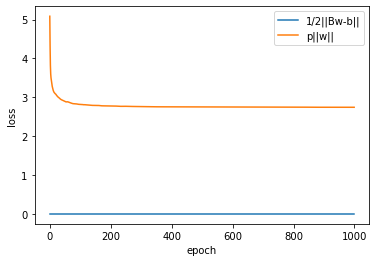

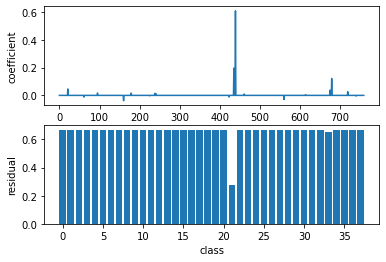

0.9166666666666666


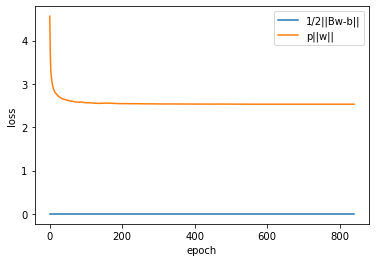

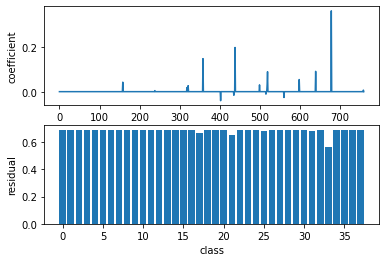

0.908256880733945


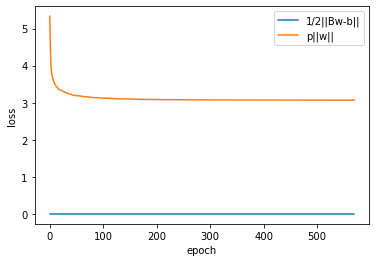

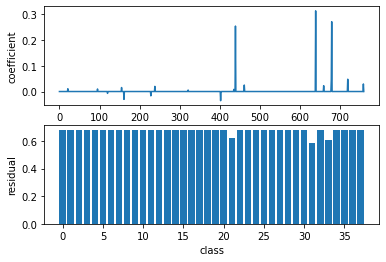

0.9


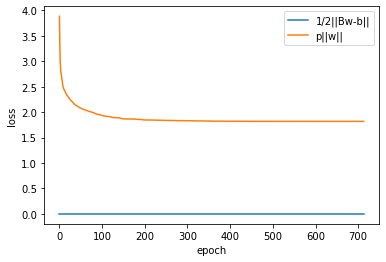

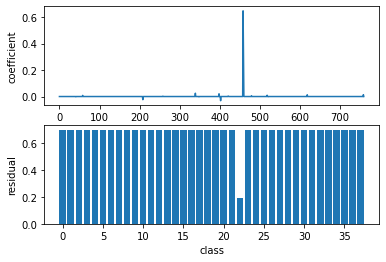

0.9009009009009009


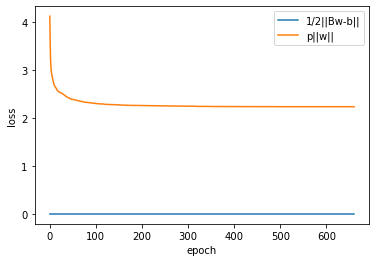

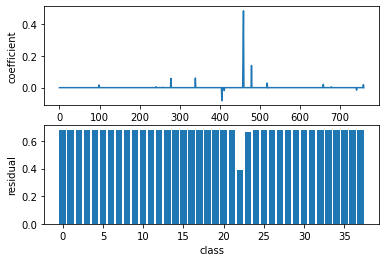

0.9017857142857143


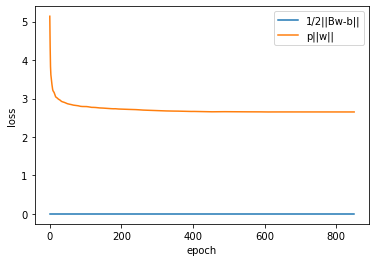

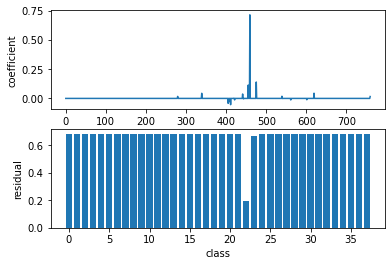

0.9026548672566371


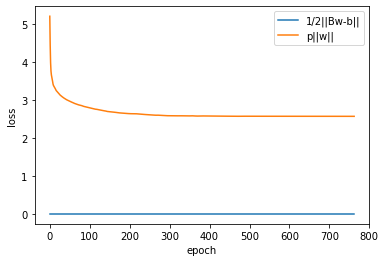

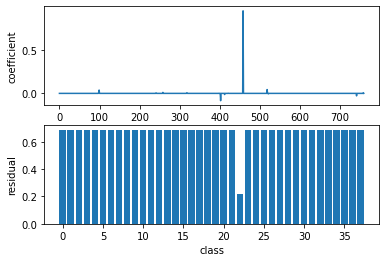

0.9035087719298246


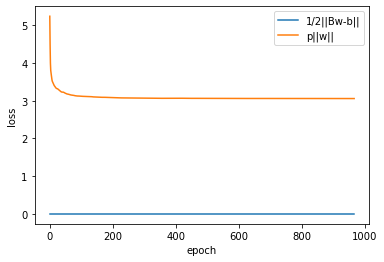

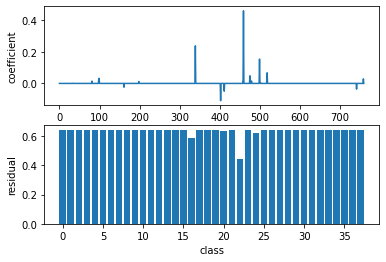

0.9043478260869565


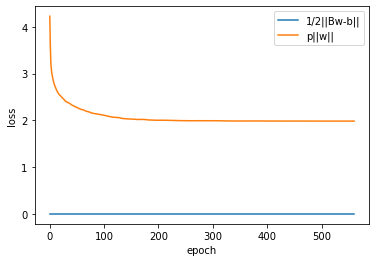

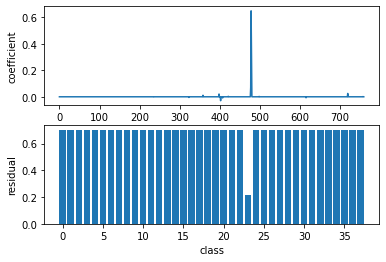

0.9051724137931034


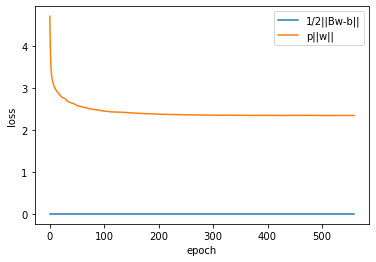

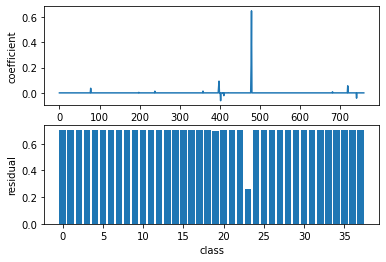

0.905982905982906


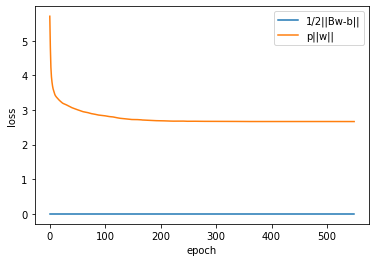

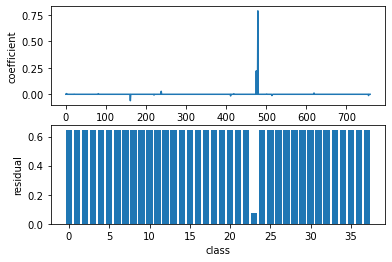

0.9067796610169492


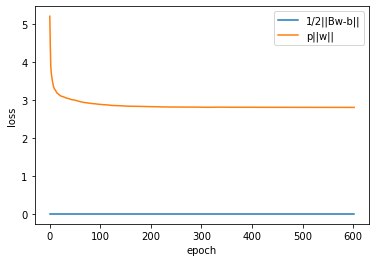

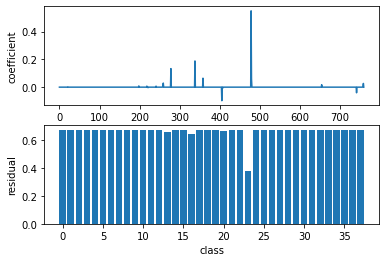

0.907563025210084


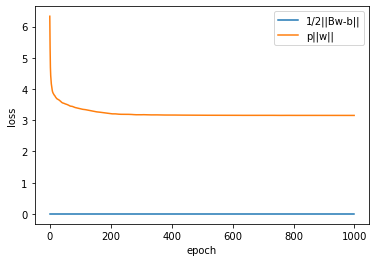

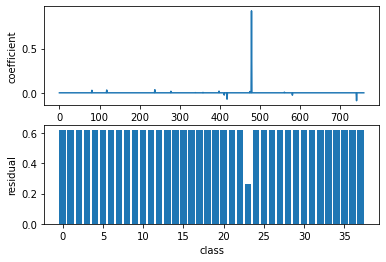

0.9083333333333333


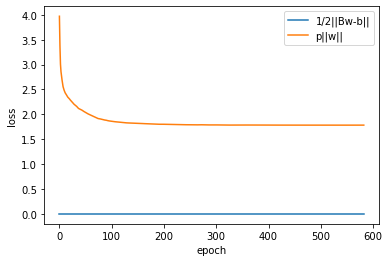

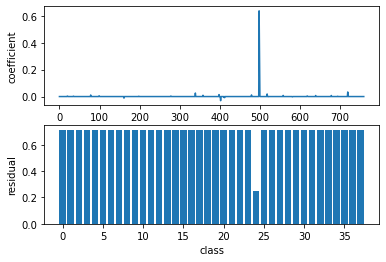

0.9090909090909091


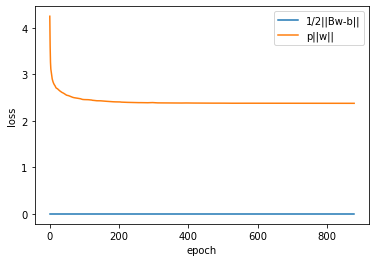

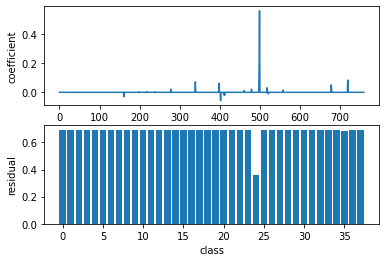

0.9098360655737705


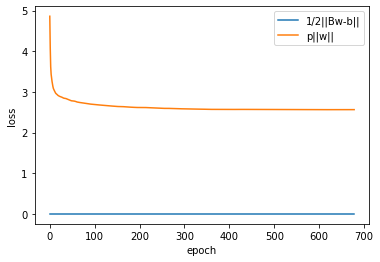

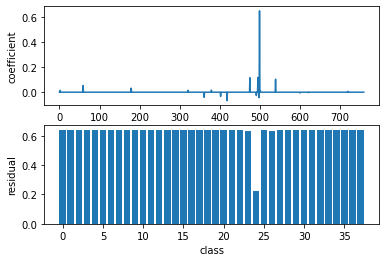

0.9105691056910569


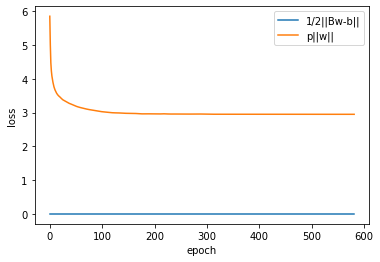

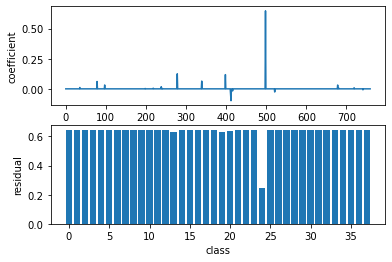

0.9112903225806451


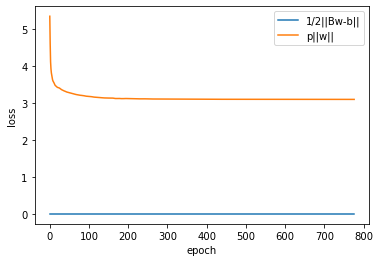

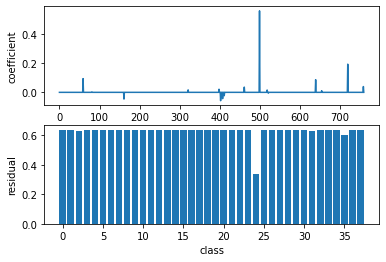

0.912


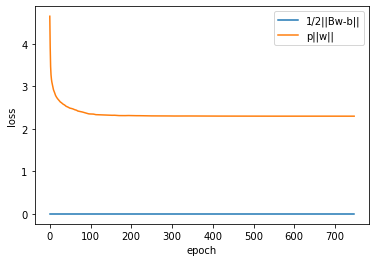

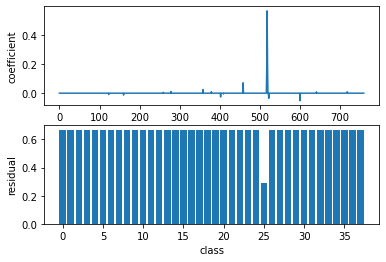

0.9126984126984127


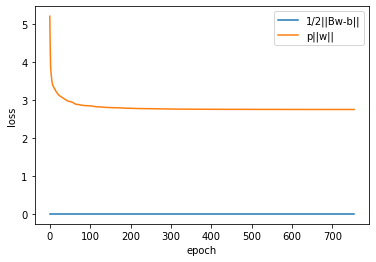

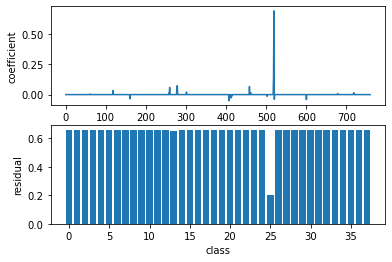

0.9133858267716536


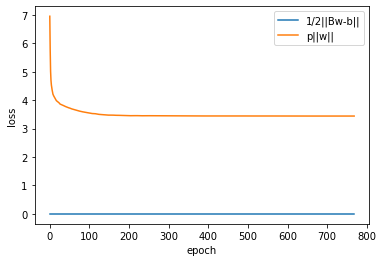

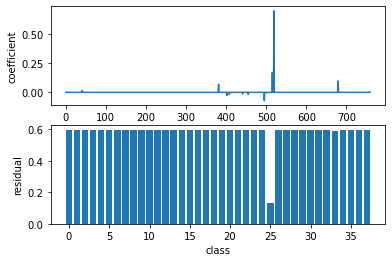

0.9140625


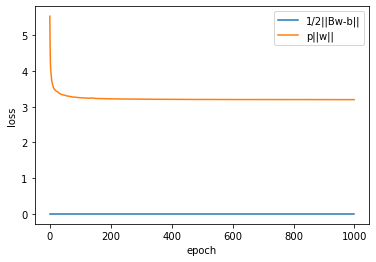

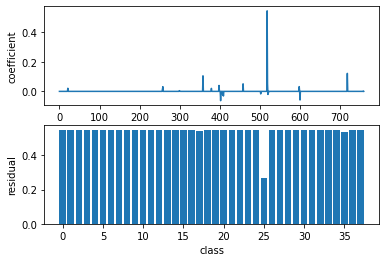

0.9147286821705426


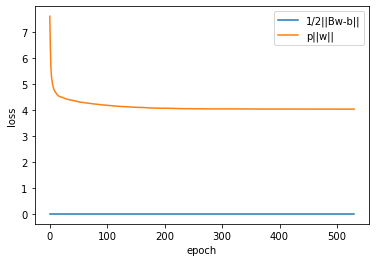

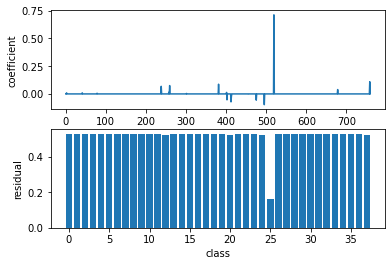

0.9153846153846154


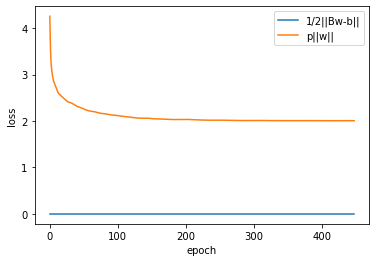

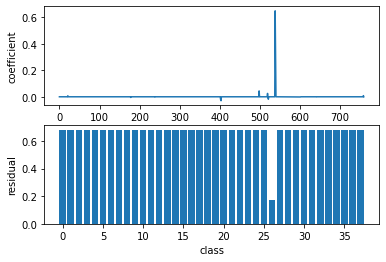

0.916030534351145


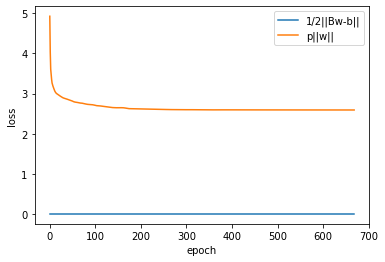

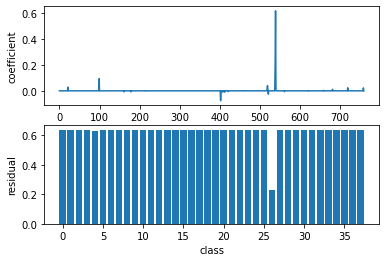

0.9166666666666666


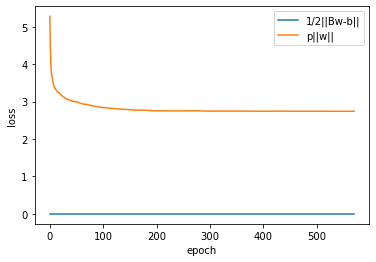

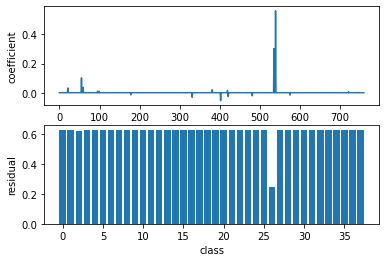

0.9172932330827067


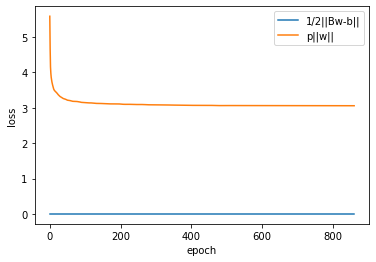

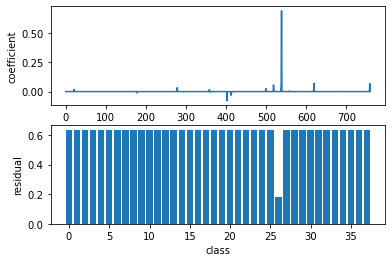

0.917910447761194


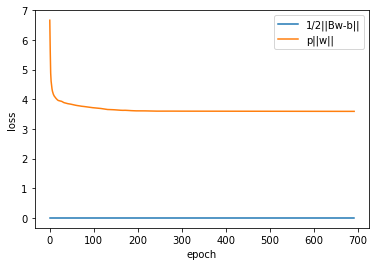

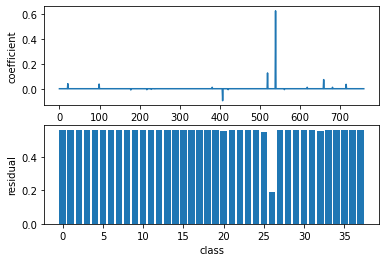

0.9185185185185185


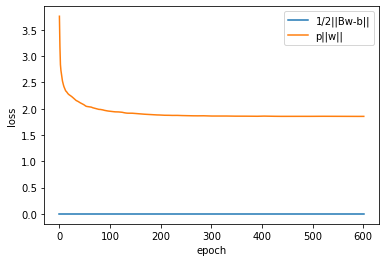

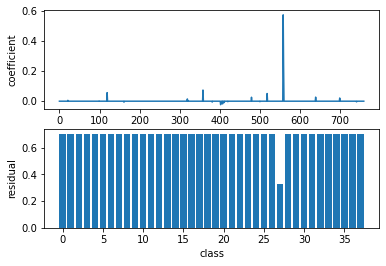

0.9191176470588235


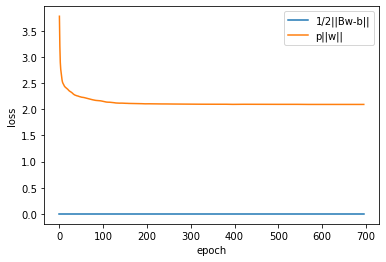

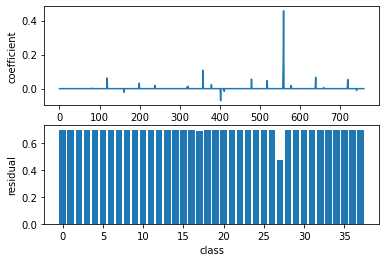

0.9197080291970803


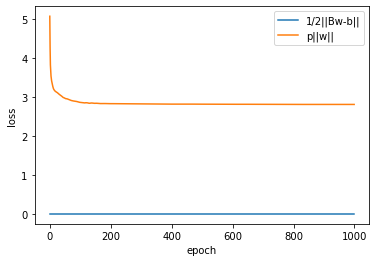

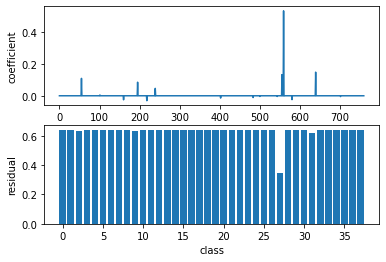

0.9202898550724637


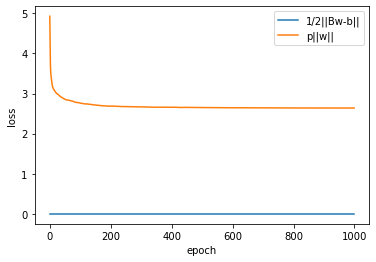

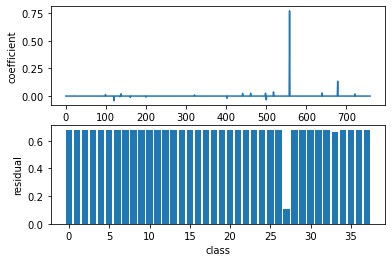

0.920863309352518


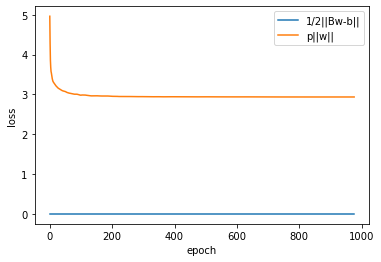

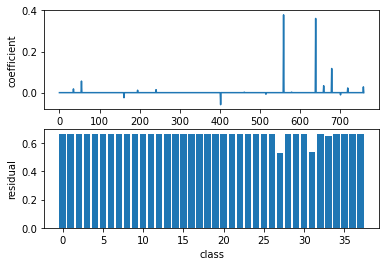

0.9214285714285714


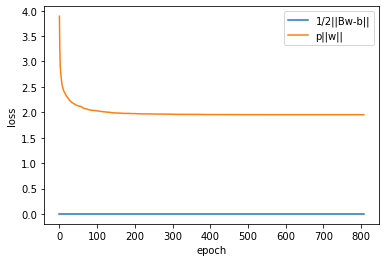

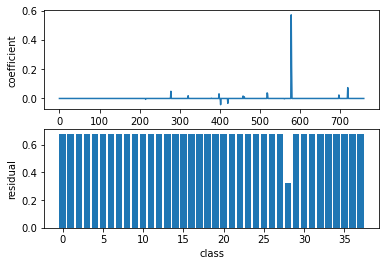

0.9219858156028369


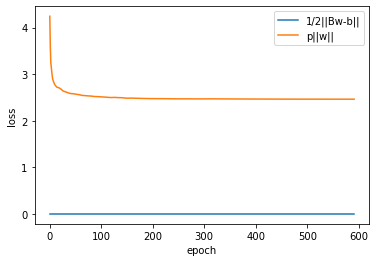

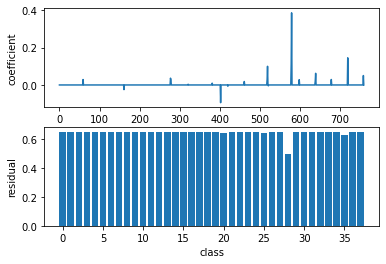

0.9225352112676056


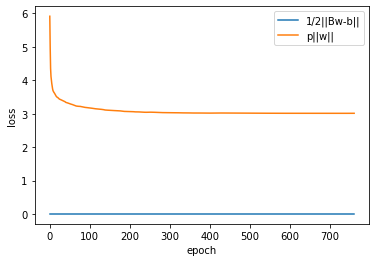

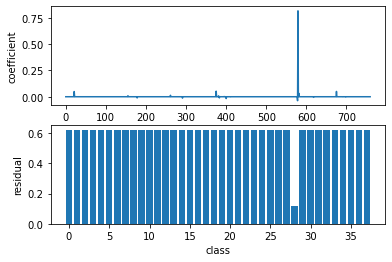

0.9230769230769231


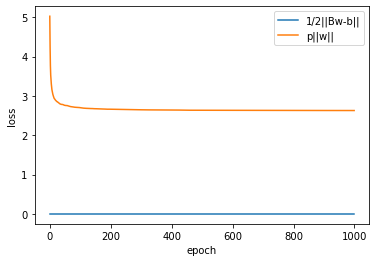

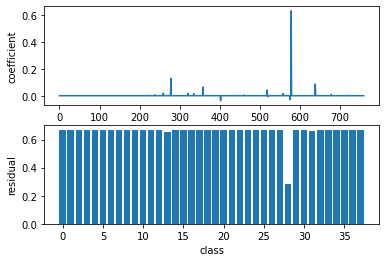

0.9236111111111112


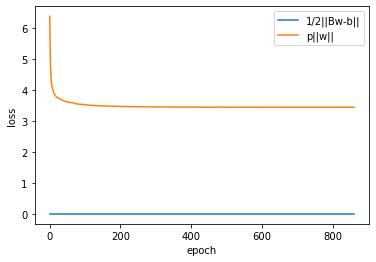

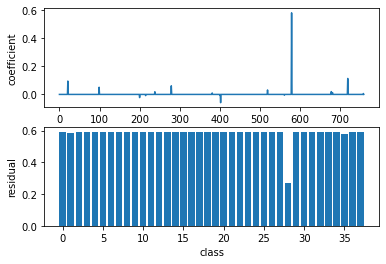

0.9241379310344827


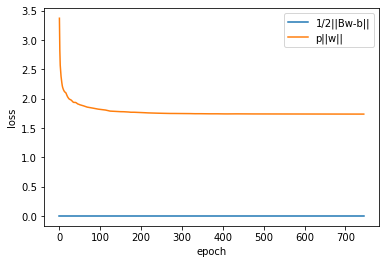

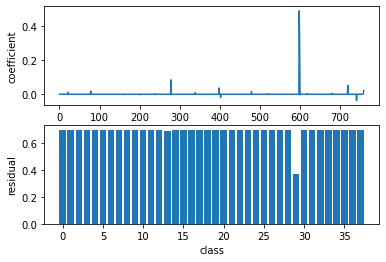

0.9246575342465754


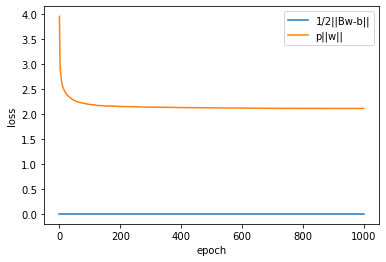

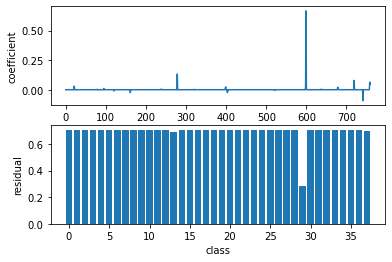

0.9251700680272109


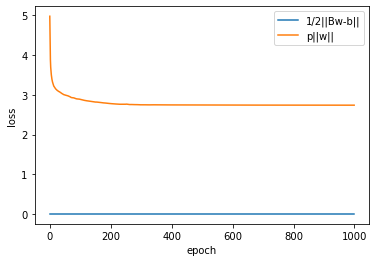

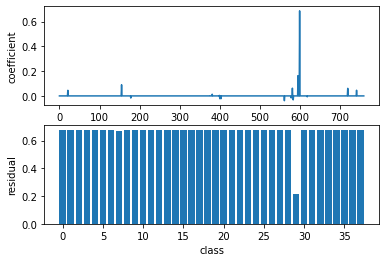

0.9256756756756757


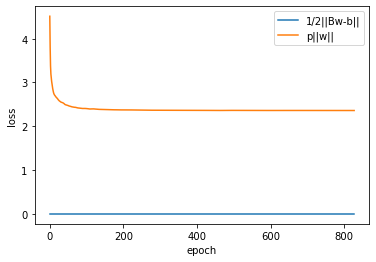

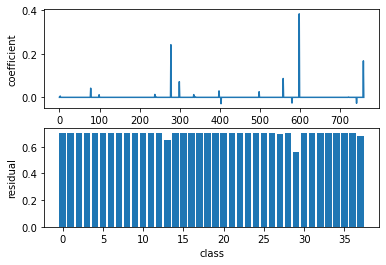

0.9261744966442953


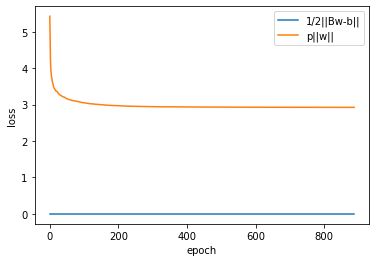

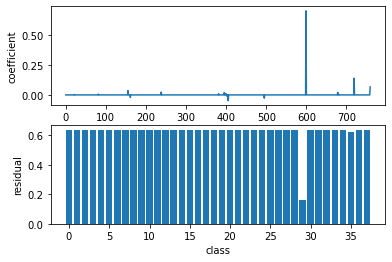

0.9266666666666666


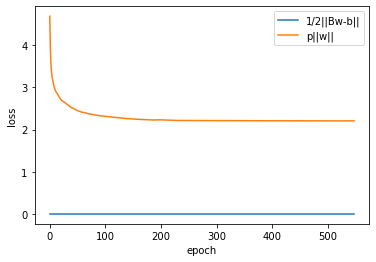

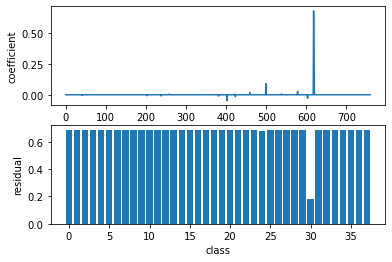

0.9271523178807947


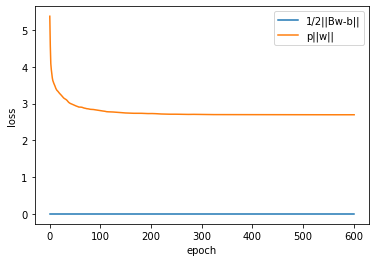

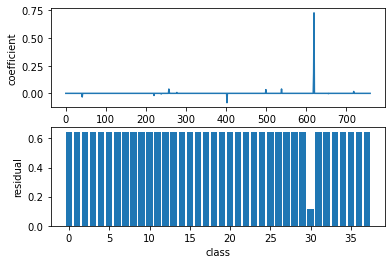

0.9276315789473685


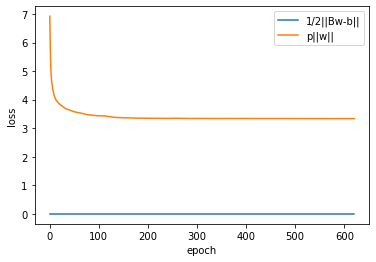

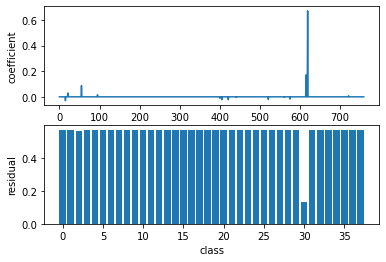

0.9281045751633987


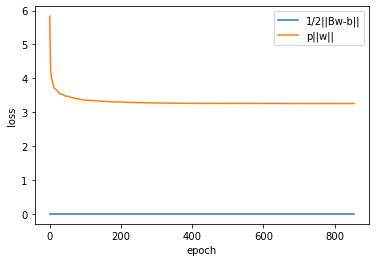

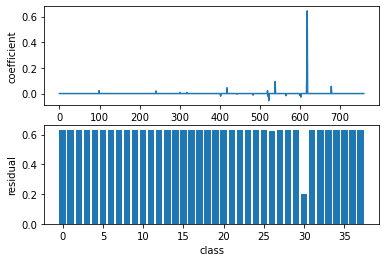

0.9285714285714286


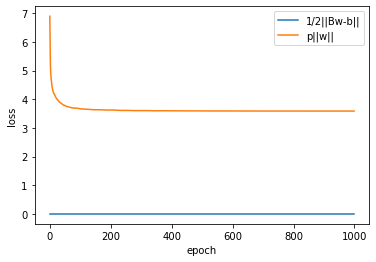

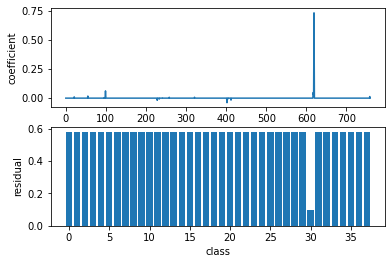

0.9290322580645162


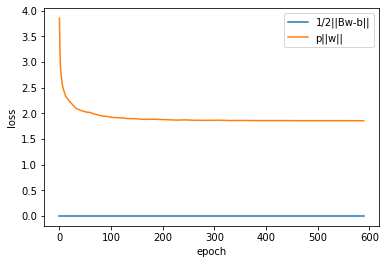

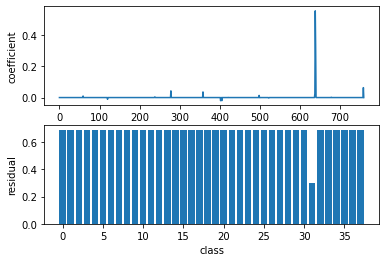

0.9294871794871795


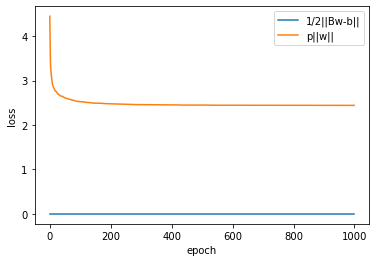

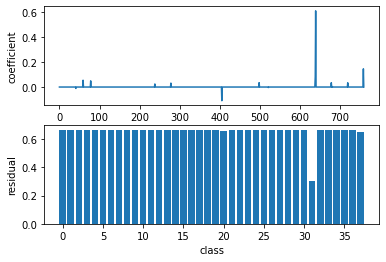

0.9299363057324841


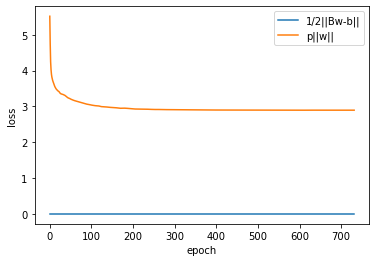

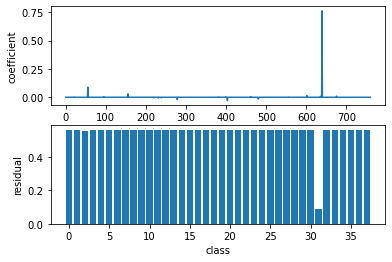

0.930379746835443


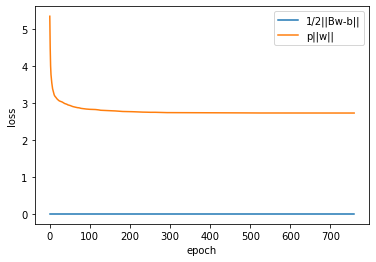

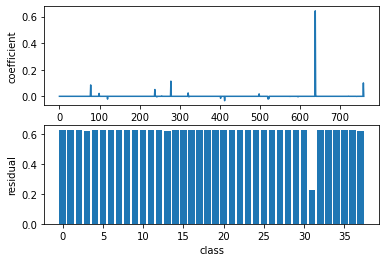

0.9308176100628931


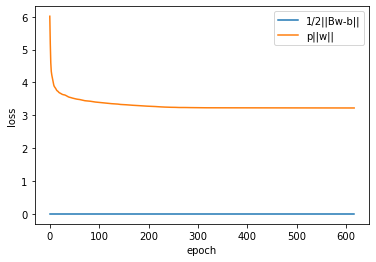

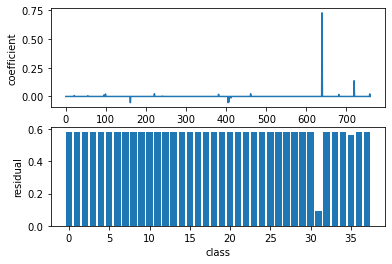

0.93125


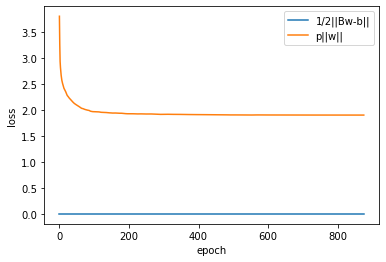

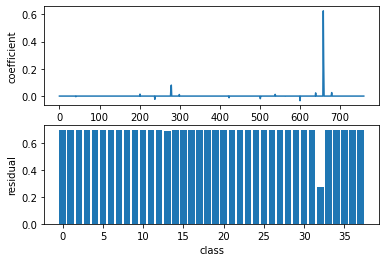

0.9316770186335404


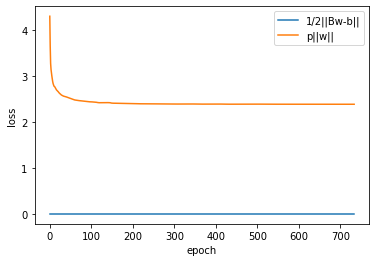

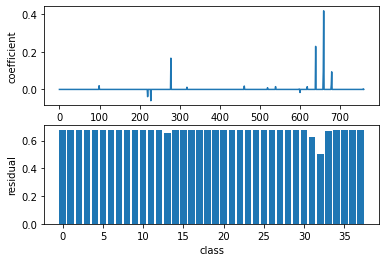

0.9320987654320988


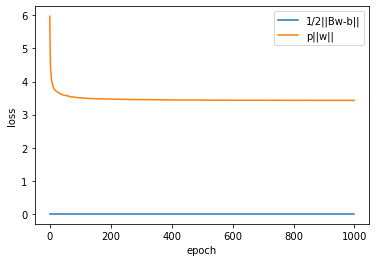

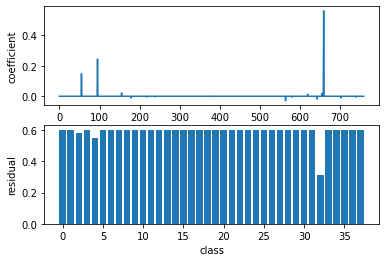

0.9325153374233128


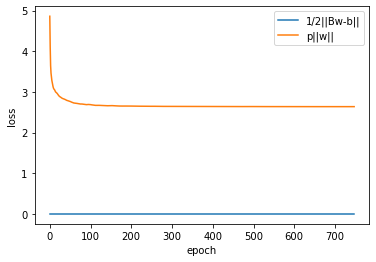

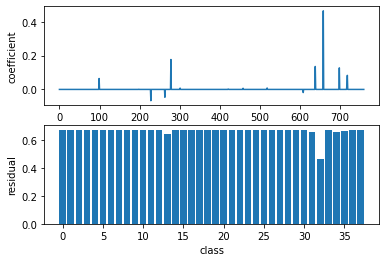

0.9329268292682927


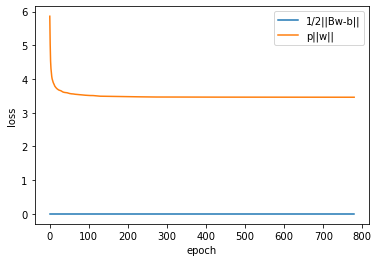

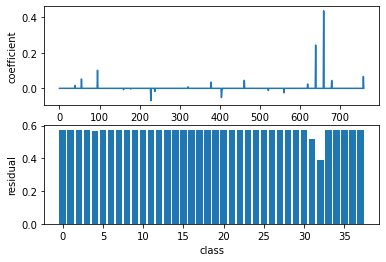

0.9333333333333333


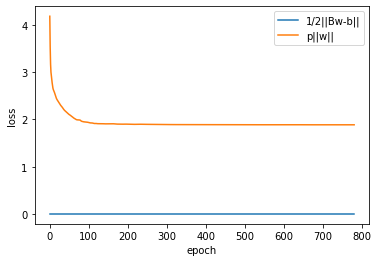

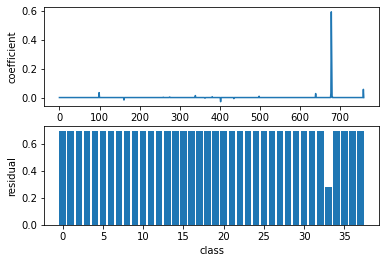

0.9337349397590361


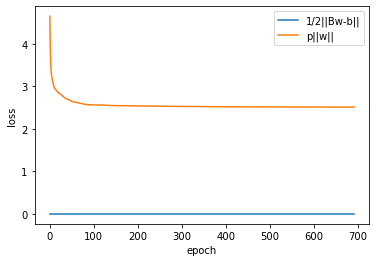

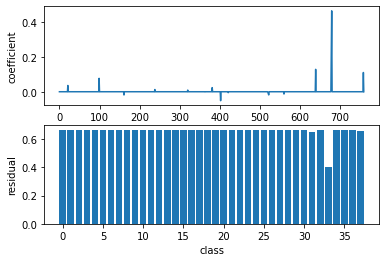

0.9341317365269461


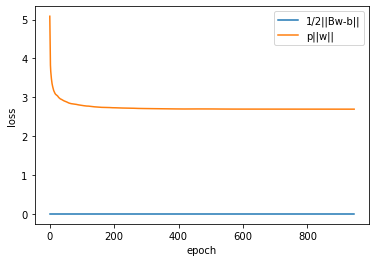

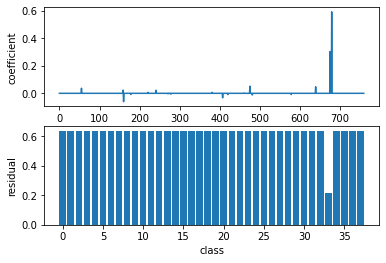

0.9345238095238095


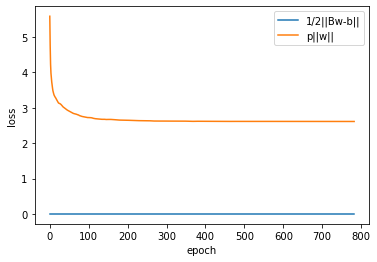

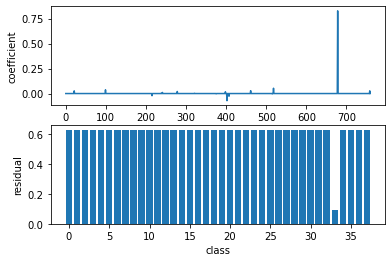

0.9349112426035503


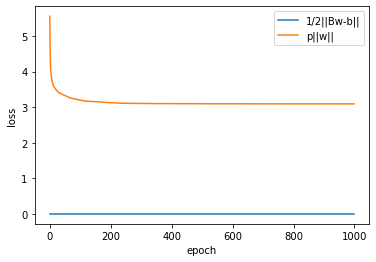

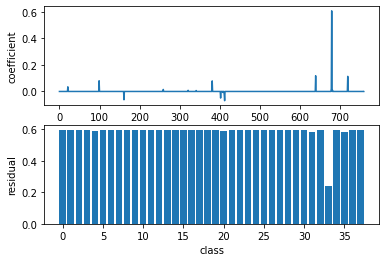

0.9352941176470588


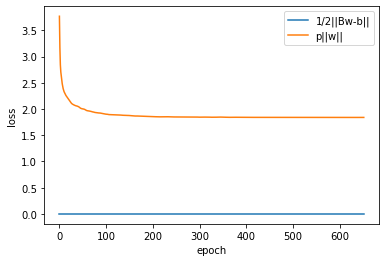

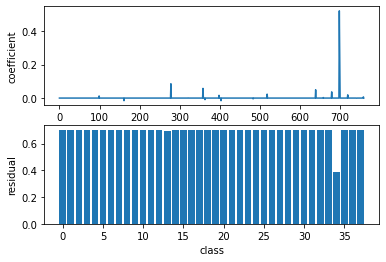

0.935672514619883


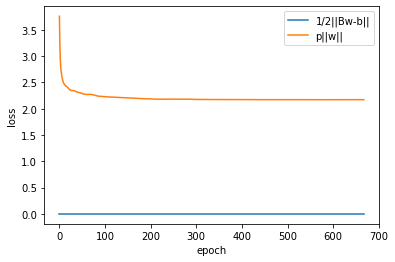

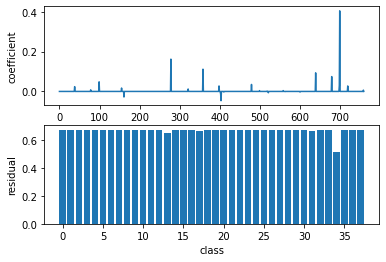

0.936046511627907


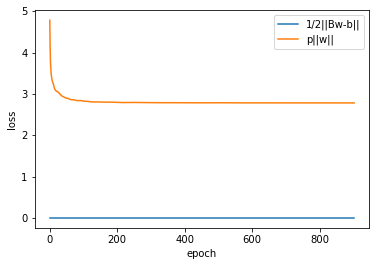

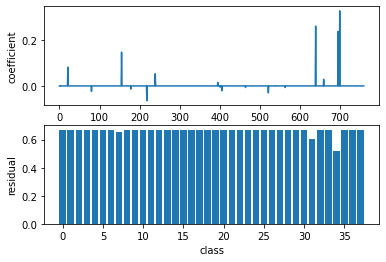

0.9364161849710982


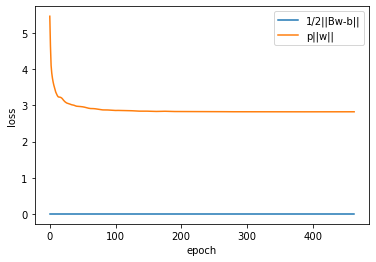

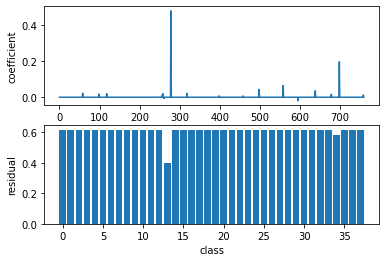

0.9310344827586207


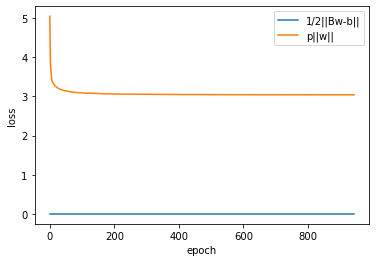

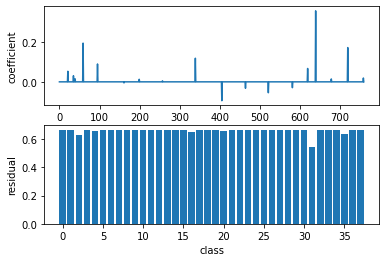

0.9257142857142857


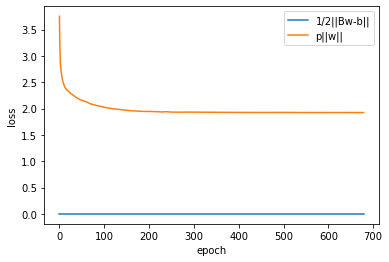

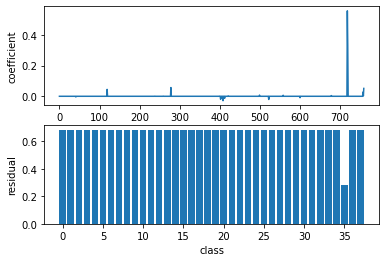

0.9261363636363636


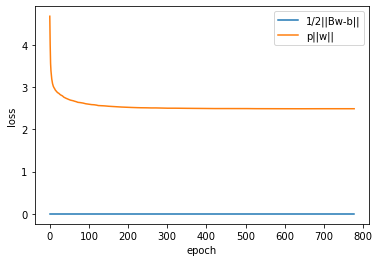

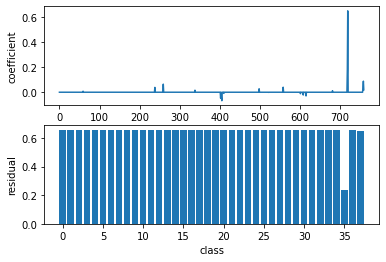

0.9265536723163842


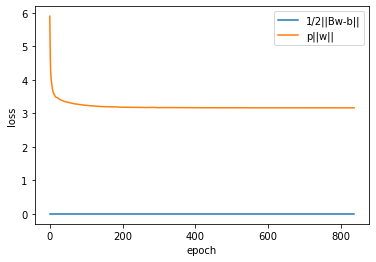

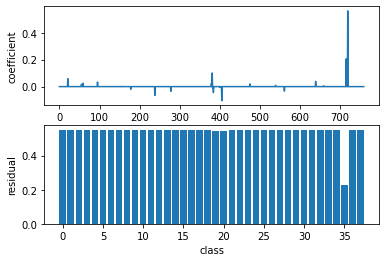

0.9269662921348315


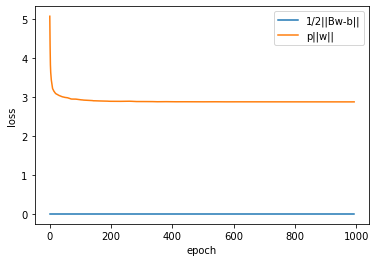

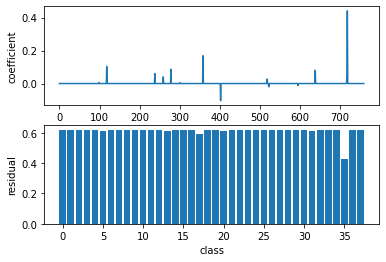

0.9273743016759777


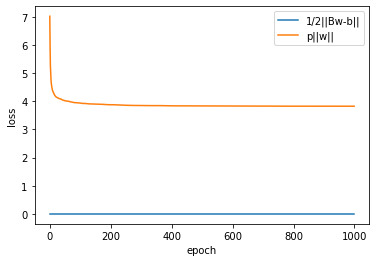

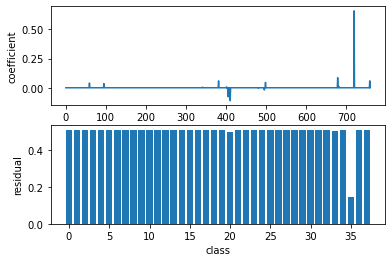

0.9277777777777778


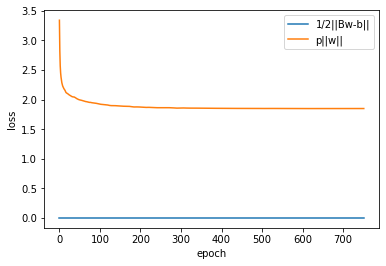

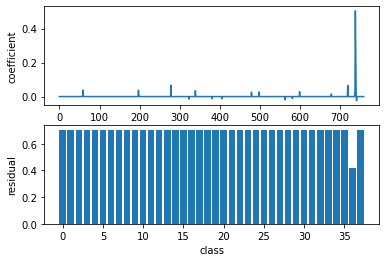

0.9281767955801105


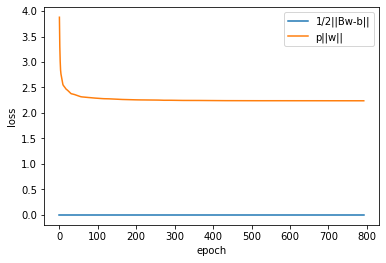

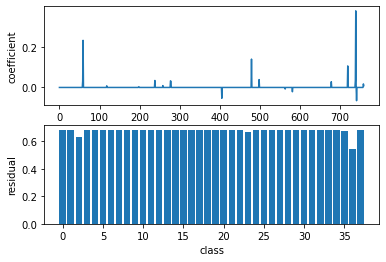

0.9285714285714286


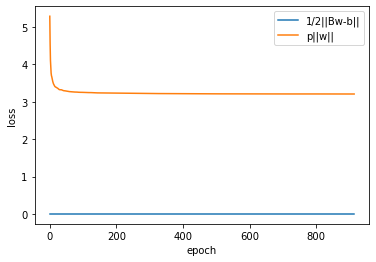

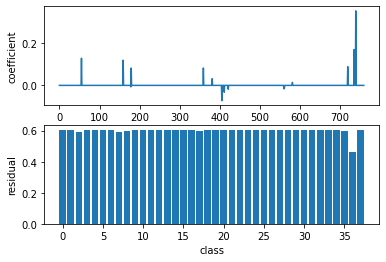

0.9289617486338798


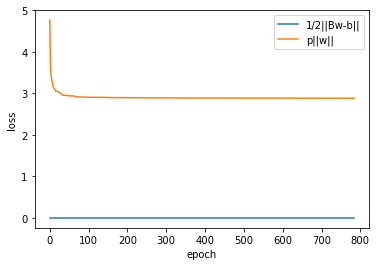

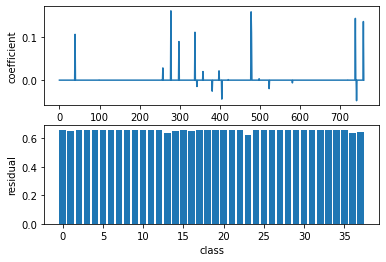

0.9239130434782609


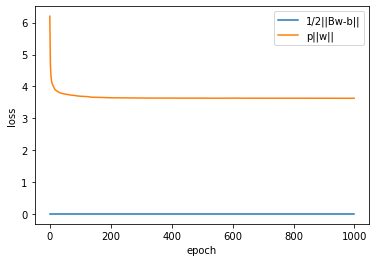

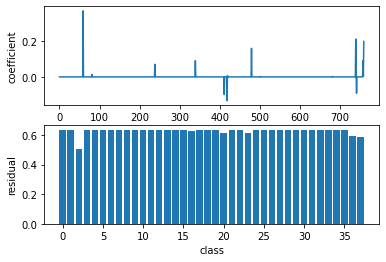

0.918918918918919


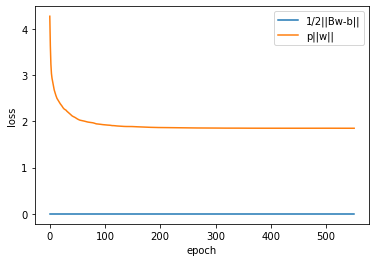

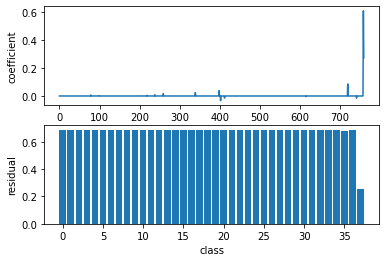

0.9193548387096774


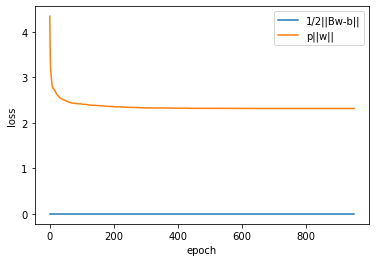

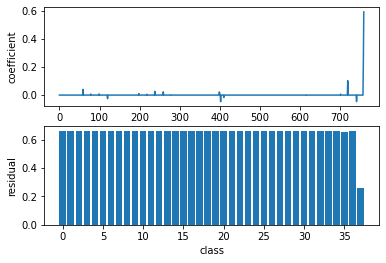

0.9197860962566845


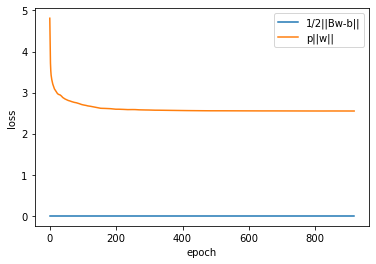

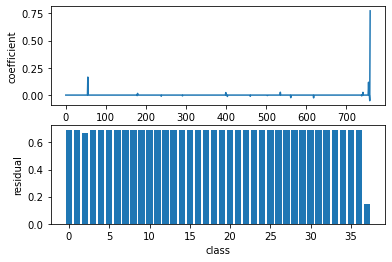

0.9202127659574468


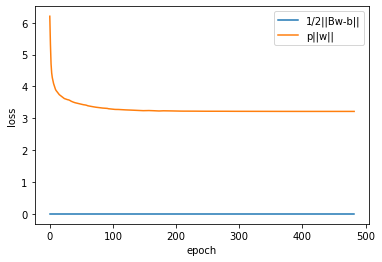

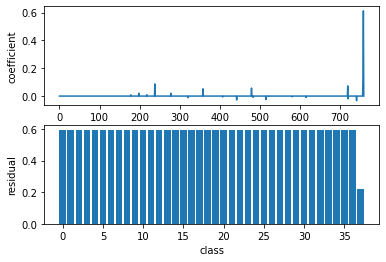

0.9206349206349206


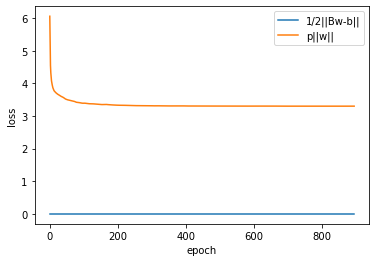

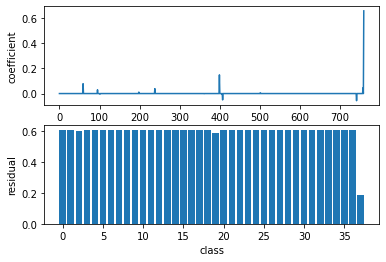

0.9210526315789473
测试结束，平均用时0.568s
accuracy=0.921


In [4]:
import time

correct = 0
total = 0
t_sta = time.time()
for classi in test_data:
    for y in test_data[classi]:
        src_i = sparse_representation_classify(RA, y, 1e-4, len(test_data), lasso_dalm, display=True)
        if src_i == class2index[classi]:
            correct += 1
        total += 1
        print(correct / total)
t_total = time.time() - t_sta
print("测试结束，平均用时{:.3f}s".format(t_total / total))
print("accuracy={:.3f}".format(correct / total))